In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde

In [24]:
from numba import vectorize, float64, guvectorize, jit

## LOAD DATASET

In [25]:
# GENERATE DATA FROM STABLE DISTRI
@jit(nopython=True)
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = np.pi / 2 * (2 * np.random.rand(num_datasets, dataset_size) - 1)
    W = - np.log(np.random.rand(num_datasets, dataset_size))
    #r = np.zeros(n)

    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        b = math.atan(const)
        s = (1 + const * const)**(1 / (2 * alpha))
        r = s * np.sin(alpha * V + b) / ((np.cos(V)) ** (1/alpha)) * (( np.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
        r = gamma * r + delta
    else:
        piover2 = np.pi / 2
        sclshftV = piover2 + beta * V
        r = 1/piover2 * (sclshftV * np.tan(V) - beta * np.log( (piover2 * W * np.cos(V) ) / sclshftV ))
        r = gamma * r + (2 / np.pi) * beta * gamma * np.log(gamma) + delta
    return r

actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 10)
actual_data

array([[-1.58756748, -0.81953394,  0.48933925, ..., -0.28447071,
         0.65531688, -0.71531382],
       [-0.90055107, -0.82558763, -0.0672247 , ..., -1.25646478,
        -0.85536799, -0.18158719],
       [ 1.0463486 , -0.30127276,  1.30547561, ..., -1.30448643,
         3.57914019, -1.58927451],
       ...,
       [-1.2141426 ,  3.71513455,  3.50401625, ..., -1.48085123,
         0.65684343,  0.64046819],
       [-0.65833821, -1.6778037 ,  1.9368994 , ...,  0.81598389,
         0.20644841,  3.91803787],
       [ 1.51760338,  1.75917755,  0.0944422 , ...,  1.73277186,
        -0.05784505,  0.27018417]])

In [26]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data: np.ndarray) -> np.ndarray:
  # Compute quantile statistics
  v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
  v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
  v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
  v_loc = np.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
  tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
  tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
  tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
  dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
  if dist_stability != 0:
    dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

  dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
  t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
  t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
  t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

  dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
  if dist_stability != 0:
    dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

  dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

  if abs(alpha-1) < 0.05:
    mu = zeta
  else:
    mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

  return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

# actual_summary_statistics = alpha_stable_ss(actual_data)
# actual_summary_statistics

In [27]:
@jit
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = np.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [28]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([1.45905027, 0.46239575, 0.98317796, 0.00651455])

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [29]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 100 # number of datasets
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def summary_statistics(self, theta):
        sample_mean, sample_variance = summary_statistics(theta, 200, self.num_datasets)
        return sample_mean, sample_variance

    def prior(self, theta): 
        log_prior = multivariate_normal.logpdf(theta, cov= 100 * np.identity(self.num_coeffs))
        
        return log_prior

    def unbiased_log_likelihood(self, theta):
        sample_mean = self.summary_statistics(theta)[0]
        sample_variance = self.summary_statistics(theta)[1]
        diff_mean_s = self.actual_summary_statistics - sample_mean
        part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
        # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
        u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
        return u_est_log_likelihood

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        gradient_log_q_l = (np.diag(1 / np.diag(l)) - np.matmul(((np.reshape(theta - mu, (self.num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(self.num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        #mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1.1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (np.exp(theta_tilde_0[1]) - 1) / (np.exp(theta_tilde_0[1]) + 1)
                    gamma_0 = np.exp(theta_tilde_0[2])
                    delta_0 = theta_tilde_0[3]
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])
                    
                    # Find gradient of LB
                    h_lambda_init = self.prior(theta_tilde_0) + self.unbiased_log_likelihood(theta_0) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1.1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (np.exp(theta_tilde_q[1]) - 1) / (np.exp(theta_tilde_q[1]) + 1)
                    gamma_q = np.exp(theta_tilde_q[2])
                    delta_q = theta_tilde_q[3]
                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])
                    
                    # Find gradient of LB
                    h_lambda = self.prior(theta_tilde_q) + self.unbiased_log_likelihood(theta_q) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [30]:
# Set hyperparameters
stop = 5000

In [31]:
vb = GVB(200, actual_summary_statistics, 0.001, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/var/folders/d8/x9hvzkp5207f80bh52n_f4rw0000gn/T/ipykernel_3947/4237580040.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "summary_statistics" failed type inference due to: No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int64, array(float64, 1d, C))
 
There are 16 candidate implementations:
    - Of which 16 did not match due to:
    Overload of function 'setitem': File: <numerous>: Line N/A.
      With argument(s): '(array(undefined, 1d, C), int64, array(float64, 1d, C))':
     No match.

During: typing of setitem at /var/folders/d8/x9hvzkp5207f80bh52n_f4rw0000gn/T/ipykernel_3947/4237580040.py (4)

File "../../../../../var/folders/d8/x9hvzkp5207f80bh52n_f4rw0000gn/T/ipykernel_3947/4237580040.py", line 4:
<source missing, REPL/exec in use?>

  @jit
/anaconda3/envs/myenv/lib/python3.7/site-packages/numba/core

LB -14.33111694096081


  0%|          | 2/5000 [00:24<15:39:32, 11.28s/it]

LB -14.152912444033978


  0%|          | 3/5000 [00:31<12:30:35,  9.01s/it]

LB -14.119965498590782


  0%|          | 4/5000 [00:37<10:54:50,  7.86s/it]

LB -13.911321849110372


  0%|          | 5/5000 [00:43<10:08:38,  7.31s/it]

LB -14.235837437008236


  0%|          | 6/5000 [00:49<9:30:19,  6.85s/it] 

LB -14.048589283670522


  0%|          | 7/5000 [00:55<9:13:26,  6.65s/it]

LB -13.762749029273063


  0%|          | 8/5000 [01:03<9:51:35,  7.11s/it]

LB -14.39406010960648


  0%|          | 9/5000 [01:09<9:24:06,  6.78s/it]

LB -13.952968646336931


  0%|          | 10/5000 [01:15<8:54:57,  6.43s/it]

LB -14.20784916405733


  0%|          | 11/5000 [01:21<8:43:16,  6.29s/it]

LB -13.962015156211656


  0%|          | 12/5000 [01:28<8:48:48,  6.36s/it]

LB -13.741472552810176


  0%|          | 13/5000 [01:34<8:43:19,  6.30s/it]

LB -14.397210539195148


  0%|          | 14/5000 [01:40<8:53:26,  6.42s/it]

LB -13.976470432872201


  0%|          | 15/5000 [01:46<8:44:15,  6.31s/it]

LB -13.824424811967818


  0%|          | 16/5000 [01:54<9:09:23,  6.61s/it]

LB -13.952665121420482


  0%|          | 17/5000 [02:01<9:20:34,  6.75s/it]

LB -14.496428919525835


  0%|          | 18/5000 [02:08<9:37:43,  6.96s/it]

LB -13.808853182015868


  0%|          | 19/5000 [02:17<10:21:42,  7.49s/it]

LB -13.385380307793364


  0%|          | 20/5000 [02:23<9:39:14,  6.98s/it] 

LB -14.137679561736855


  0%|          | 21/5000 [02:29<9:12:45,  6.66s/it]

LB -14.089308840598587


  0%|          | 22/5000 [02:34<8:49:36,  6.38s/it]

LB -13.70209514673647


  0%|          | 23/5000 [02:43<9:33:37,  6.92s/it]

LB -13.603253970966476


  0%|          | 24/5000 [02:50<9:51:32,  7.13s/it]

LB -14.182505838218697


  0%|          | 25/5000 [03:07<13:43:47,  9.94s/it]

LB -14.089708385999698


  1%|          | 26/5000 [03:21<15:35:00, 11.28s/it]

LB -13.8102706520908


  1%|          | 27/5000 [03:38<17:47:08, 12.88s/it]

LB -13.918685710596538


  1%|          | 28/5000 [03:49<16:57:49, 12.28s/it]

LB -13.820334722638476


  1%|          | 29/5000 [03:58<15:40:36, 11.35s/it]

LB -13.965673106135801


  1%|          | 30/5000 [04:05<13:55:46, 10.09s/it]

LB -13.844145967497154


  1%|          | 31/5000 [04:12<12:41:49,  9.20s/it]

LB -13.478789989391423


  1%|          | 32/5000 [04:19<11:51:35,  8.59s/it]

LB -14.051068832849612


  1%|          | 33/5000 [04:27<11:19:35,  8.21s/it]

LB -13.775529111365682


  1%|          | 34/5000 [04:35<11:19:25,  8.21s/it]

LB -13.75767181620558


  1%|          | 35/5000 [04:43<11:10:22,  8.10s/it]

LB -13.85021633590007


  1%|          | 36/5000 [04:50<10:49:01,  7.84s/it]

LB -13.878791026771408


  1%|          | 37/5000 [04:57<10:34:11,  7.67s/it]

LB -13.79232377086632


  1%|          | 38/5000 [05:05<10:50:56,  7.87s/it]

LB -13.705957818285857


  1%|          | 39/5000 [05:14<11:18:44,  8.21s/it]

LB -13.767865195421853


  1%|          | 40/5000 [05:21<10:31:25,  7.64s/it]

LB -13.906971053647647


  1%|          | 41/5000 [05:26<9:41:09,  7.03s/it] 

LB -13.661708681259311


  1%|          | 42/5000 [05:32<9:10:07,  6.66s/it]

LB -14.019325854784618


  1%|          | 43/5000 [05:38<8:52:22,  6.44s/it]

LB -13.706010416722108


  1%|          | 44/5000 [05:45<9:04:48,  6.60s/it]

LB -13.792664719674956


  1%|          | 45/5000 [05:53<9:33:02,  6.94s/it]

LB -14.005404182444074


  1%|          | 46/5000 [05:59<9:20:53,  6.79s/it]

LB -14.021074702716765


  1%|          | 47/5000 [06:07<9:49:48,  7.14s/it]

LB -14.002864772153298


  1%|          | 48/5000 [06:14<9:46:05,  7.10s/it]

LB -14.043563275151742


  1%|          | 49/5000 [06:22<9:51:20,  7.17s/it]

LB -13.799552697039115


  1%|          | 50/5000 [06:30<10:16:29,  7.47s/it]

LB -13.705576516255906


  1%|          | 51/5000 [06:36<9:47:22,  7.12s/it] 

LB Smoothed -13.92281157464537


  1%|          | 52/5000 [06:43<9:32:37,  6.94s/it]

LB Smoothed -13.915228101412517


  1%|          | 53/5000 [06:49<9:24:34,  6.85s/it]

LB Smoothed -13.911599743146583


  1%|          | 54/5000 [06:56<9:18:48,  6.78s/it]

LB Smoothed -13.91247434378362


  1%|          | 55/5000 [07:03<9:32:50,  6.95s/it]

LB Smoothed -13.899907464772681


  1%|          | 56/5000 [07:10<9:20:38,  6.80s/it]

LB Smoothed -13.884412974330145


  1%|          | 57/5000 [07:16<9:07:16,  6.64s/it]

LB Smoothed -13.884783709922235


  1%|          | 58/5000 [07:22<9:03:46,  6.60s/it]

LB Smoothed -13.87812510765548


  1%|          | 59/5000 [07:29<8:54:05,  6.49s/it]

LB Smoothed -13.875736669157005


  1%|          | 60/5000 [07:35<8:47:15,  6.40s/it]

LB Smoothed -13.86402709099252


  1%|          | 61/5000 [07:41<8:41:41,  6.34s/it]

LB Smoothed -13.86455673612051


  1%|          | 62/5000 [07:47<8:38:48,  6.30s/it]

LB Smoothed -13.859918214984221


  1%|▏         | 63/5000 [07:54<8:40:13,  6.32s/it]

LB Smoothed -13.84661051766621


  1%|▏         | 64/5000 [08:00<8:38:53,  6.31s/it]

LB Smoothed -13.843443201861803


  1%|▏         | 65/5000 [08:06<8:43:56,  6.37s/it]

LB Smoothed -13.840214481305923


  1%|▏         | 66/5000 [08:13<8:40:01,  6.32s/it]

LB Smoothed -13.839432154581454


  1%|▏         | 67/5000 [08:19<8:37:12,  6.29s/it]

LB Smoothed -13.820601588058654


  1%|▏         | 68/5000 [08:25<8:33:59,  6.25s/it]

LB Smoothed -13.820488165824306


  1%|▏         | 69/5000 [08:32<8:44:15,  6.38s/it]

LB Smoothed -13.824289100901836


  1%|▏         | 70/5000 [08:39<8:58:11,  6.55s/it]

LB Smoothed -13.81200655485613


  1%|▏         | 71/5000 [08:45<8:59:47,  6.57s/it]

LB Smoothed -13.80222214843981


  1%|▏         | 72/5000 [08:52<8:58:47,  6.56s/it]

LB Smoothed -13.794204657005599


  1%|▏         | 73/5000 [08:58<9:01:27,  6.59s/it]

LB Smoothed -13.794483248805864


  1%|▏         | 74/5000 [09:05<9:01:18,  6.59s/it]

LB Smoothed -13.781639847226444


  2%|▏         | 75/5000 [09:11<8:57:12,  6.54s/it]

LB Smoothed -13.77516258474192


  2%|▏         | 76/5000 [09:18<8:59:42,  6.58s/it]

LB Smoothed -13.769859884041285


  2%|▏         | 77/5000 [09:25<9:01:08,  6.60s/it]

LB Smoothed -13.764125181509552


  2%|▏         | 78/5000 [09:31<8:58:28,  6.56s/it]

LB Smoothed -13.761446703963227


  2%|▏         | 79/5000 [09:38<9:00:58,  6.60s/it]

LB Smoothed -13.757164191204676


  2%|▏         | 80/5000 [09:45<9:01:48,  6.61s/it]

LB Smoothed -13.754165028724131


  2%|▏         | 81/5000 [09:51<8:56:26,  6.54s/it]

LB Smoothed -13.751962250259604


  2%|▏         | 82/5000 [09:57<8:52:56,  6.50s/it]

LB Smoothed -13.741864119198866


  2%|▏         | 83/5000 [10:04<8:58:48,  6.57s/it]

LB Smoothed -13.740868921102512


  2%|▏         | 84/5000 [10:11<9:01:15,  6.61s/it]

LB Smoothed -13.742146316217433


  2%|▏         | 85/5000 [10:17<9:01:33,  6.61s/it]

LB Smoothed -13.731209515707095


  2%|▏         | 86/5000 [10:24<8:57:34,  6.56s/it]

LB Smoothed -13.728182042747395


  2%|▏         | 87/5000 [10:30<8:47:03,  6.44s/it]

LB Smoothed -13.722375359023467


  2%|▏         | 88/5000 [10:36<8:45:25,  6.42s/it]

LB Smoothed -13.715162571456853


  2%|▏         | 89/5000 [10:43<8:51:49,  6.50s/it]

LB Smoothed -13.712300209309896


  2%|▏         | 90/5000 [10:49<8:49:27,  6.47s/it]

LB Smoothed -13.702025518740513


  2%|▏         | 91/5000 [10:56<8:58:27,  6.58s/it]

LB Smoothed -13.695034365958485


  2%|▏         | 92/5000 [11:03<9:02:10,  6.63s/it]

LB Smoothed -13.68401564195859


  2%|▏         | 93/5000 [11:10<9:08:50,  6.71s/it]

LB Smoothed -13.682429139690287


  2%|▏         | 94/5000 [11:17<9:18:28,  6.83s/it]

LB Smoothed -13.674403361813281


  2%|▏         | 95/5000 [11:24<9:13:54,  6.78s/it]

LB Smoothed -13.664645719182403


  2%|▏         | 96/5000 [11:30<9:05:36,  6.68s/it]

LB Smoothed -13.65495998488193


  2%|▏         | 97/5000 [11:36<8:53:38,  6.53s/it]

LB Smoothed -13.64024013376117


  2%|▏         | 98/5000 [11:43<8:47:50,  6.46s/it]

LB Smoothed -13.631408317539348


  2%|▏         | 99/5000 [11:49<8:42:54,  6.40s/it]

LB Smoothed -13.62143415096444


  2%|▏         | 100/5000 [11:55<8:36:49,  6.33s/it]

LB Smoothed -13.613166309888229


  2%|▏         | 101/5000 [12:01<8:38:51,  6.35s/it]

LB Smoothed -13.607258185828204


  2%|▏         | 102/5000 [12:08<8:42:35,  6.40s/it]

LB Smoothed -13.601253904189061


  2%|▏         | 103/5000 [12:14<8:40:23,  6.38s/it]

LB Smoothed -13.589267031627937


  2%|▏         | 104/5000 [12:21<8:36:11,  6.33s/it]

LB Smoothed -13.58441161298227


  2%|▏         | 105/5000 [12:27<8:33:22,  6.29s/it]

LB Smoothed -13.586209242845904


  2%|▏         | 106/5000 [12:33<8:36:51,  6.34s/it]

LB Smoothed -13.57926589438791


  2%|▏         | 107/5000 [12:39<8:34:07,  6.30s/it]

LB Smoothed -13.562092397063177


  2%|▏         | 108/5000 [12:46<8:37:41,  6.35s/it]

LB Smoothed -13.557380322799006


  2%|▏         | 109/5000 [12:52<8:42:40,  6.41s/it]

LB Smoothed -13.558281479706876


  2%|▏         | 110/5000 [12:59<8:38:32,  6.36s/it]

LB Smoothed -13.548011176578008


  2%|▏         | 111/5000 [13:05<8:39:10,  6.37s/it]

LB Smoothed -13.546431806726652


  2%|▏         | 112/5000 [13:11<8:36:48,  6.34s/it]

LB Smoothed -13.537598415513722


  2%|▏         | 113/5000 [13:18<8:36:54,  6.35s/it]

LB Smoothed -13.531534248279552


  2%|▏         | 114/5000 [13:24<8:29:57,  6.26s/it]

LB Smoothed -13.52743777622642


  2%|▏         | 115/5000 [13:30<8:28:50,  6.25s/it]

LB Smoothed -13.519430286858057


  2%|▏         | 116/5000 [13:36<8:28:49,  6.25s/it]

LB Smoothed -13.51860425916579


  2%|▏         | 117/5000 [13:43<8:36:52,  6.35s/it]

LB Smoothed -13.50993584212745


  2%|▏         | 118/5000 [13:50<8:51:16,  6.53s/it]

LB Smoothed -13.509423273305647


  2%|▏         | 119/5000 [13:56<8:53:11,  6.55s/it]

LB Smoothed -13.509131331662715


  2%|▏         | 120/5000 [14:03<8:53:23,  6.56s/it]

LB Smoothed -13.511012366769336


  2%|▏         | 121/5000 [14:10<9:01:15,  6.66s/it]

LB Smoothed -13.517045681198656


  2%|▏         | 122/5000 [14:17<9:02:45,  6.68s/it]

LB Smoothed -13.510711423692236


  2%|▏         | 123/5000 [14:23<9:00:38,  6.65s/it]

LB Smoothed -13.502110402156637


  2%|▏         | 124/5000 [14:30<9:00:55,  6.66s/it]

LB Smoothed -13.49941147564679


  2%|▎         | 125/5000 [14:37<9:03:33,  6.69s/it]

LB Smoothed -13.491206162774954


  3%|▎         | 126/5000 [14:43<9:01:44,  6.67s/it]

LB Smoothed -13.484932084776329


  3%|▎         | 127/5000 [14:50<9:01:34,  6.67s/it]

LB Smoothed -13.480665613620797


  3%|▎         | 128/5000 [14:57<9:07:47,  6.75s/it]

LB Smoothed -13.477464166051194


  3%|▎         | 129/5000 [15:03<9:05:19,  6.72s/it]

LB Smoothed -13.473385014412065


  3%|▎         | 130/5000 [15:10<8:51:53,  6.55s/it]

LB Smoothed -13.471281530250705


  3%|▎         | 131/5000 [15:16<8:45:53,  6.48s/it]

LB Smoothed -13.469022120685386


  3%|▎         | 132/5000 [15:22<8:41:57,  6.43s/it]

LB Smoothed -13.459584030909527


  3%|▎         | 133/5000 [15:29<8:53:03,  6.57s/it]

LB Smoothed -13.450959672139275


  3%|▎         | 134/5000 [15:35<8:41:55,  6.44s/it]

LB Smoothed -13.450342046418163


  3%|▎         | 135/5000 [15:41<8:37:04,  6.38s/it]

LB Smoothed -13.446557983979474


  3%|▎         | 136/5000 [15:48<8:38:21,  6.39s/it]

LB Smoothed -13.446649907962575


  3%|▎         | 137/5000 [15:54<8:33:55,  6.34s/it]

LB Smoothed -13.44538815089707


  3%|▎         | 138/5000 [16:01<8:36:50,  6.38s/it]

LB Smoothed -13.442442654534183


  3%|▎         | 139/5000 [16:07<8:42:37,  6.45s/it]

LB Smoothed -13.440002575560433


  3%|▎         | 140/5000 [16:13<8:38:25,  6.40s/it]

LB Smoothed -13.436829705843152


  3%|▎         | 141/5000 [16:20<8:46:32,  6.50s/it]

LB Smoothed -13.432927709102913


  3%|▎         | 142/5000 [16:27<8:46:08,  6.50s/it]

LB Smoothed -13.425806598984742


  3%|▎         | 143/5000 [16:33<8:37:49,  6.40s/it]

LB Smoothed -13.426119805483358


  3%|▎         | 144/5000 [16:39<8:40:55,  6.44s/it]

LB Smoothed -13.420531514831087


  3%|▎         | 145/5000 [16:46<8:42:43,  6.46s/it]

LB Smoothed -13.415501578422388


  3%|▎         | 146/5000 [16:51<8:13:47,  6.10s/it]

LB Smoothed -13.41778200546652


  3%|▎         | 147/5000 [16:57<7:56:07,  5.89s/it]

LB Smoothed -13.409284840798282


  3%|▎         | 148/5000 [17:02<7:46:50,  5.77s/it]

LB Smoothed -13.409988060656168


  3%|▎         | 149/5000 [17:07<7:33:58,  5.62s/it]

LB Smoothed -13.40771611426726


  3%|▎         | 150/5000 [17:13<7:24:31,  5.50s/it]

LB Smoothed -13.40142357156877


  3%|▎         | 151/5000 [17:18<7:22:44,  5.48s/it]

LB Smoothed -13.390566395243443


  3%|▎         | 152/5000 [17:25<8:08:50,  6.05s/it]

LB Smoothed -13.387835394253798


  3%|▎         | 153/5000 [17:32<8:27:22,  6.28s/it]

LB Smoothed -13.382115365052627


  3%|▎         | 154/5000 [17:38<8:08:06,  6.04s/it]

LB Smoothed -13.380870141620731


  3%|▎         | 155/5000 [17:43<7:48:52,  5.81s/it]

LB Smoothed -13.379233887593651


  3%|▎         | 156/5000 [17:48<7:40:41,  5.71s/it]

LB Smoothed -13.386049000185148


  3%|▎         | 157/5000 [17:54<7:44:03,  5.75s/it]

LB Smoothed -13.387117433541203


  3%|▎         | 158/5000 [18:00<7:34:34,  5.63s/it]

LB Smoothed -13.381314452962632


  3%|▎         | 159/5000 [18:05<7:27:35,  5.55s/it]

LB Smoothed -13.382931777276351


  3%|▎         | 160/5000 [18:10<7:20:33,  5.46s/it]

LB Smoothed -13.380338394175126


  3%|▎         | 161/5000 [18:16<7:16:01,  5.41s/it]

LB Smoothed -13.377129120471038


  3%|▎         | 162/5000 [18:21<7:16:27,  5.41s/it]

LB Smoothed -13.370489937518817


  3%|▎         | 163/5000 [18:27<7:29:05,  5.57s/it]

LB Smoothed -13.36136244419055


  3%|▎         | 164/5000 [18:32<7:22:54,  5.50s/it]

LB Smoothed -13.35992391361729


  3%|▎         | 165/5000 [18:38<7:19:09,  5.45s/it]

LB Smoothed -13.35568791386594


  3%|▎         | 166/5000 [18:43<7:14:02,  5.39s/it]

LB Smoothed -13.350677552082942


  3%|▎         | 167/5000 [18:48<7:18:03,  5.44s/it]

LB Smoothed -13.347750704702198


  3%|▎         | 168/5000 [18:54<7:13:02,  5.38s/it]

LB Smoothed -13.344321824034045


  3%|▎         | 169/5000 [18:59<7:10:18,  5.34s/it]

LB Smoothed -13.330949930649044


  3%|▎         | 170/5000 [19:04<7:07:38,  5.31s/it]

LB Smoothed -13.32457487930849


  3%|▎         | 171/5000 [19:10<7:16:10,  5.42s/it]

LB Smoothed -13.32588134799312


  3%|▎         | 172/5000 [19:15<7:15:19,  5.41s/it]

LB Smoothed -13.326637527993828


  3%|▎         | 173/5000 [19:20<7:11:43,  5.37s/it]

LB Smoothed -13.319396800447779


  3%|▎         | 174/5000 [19:26<7:08:38,  5.33s/it]

LB Smoothed -13.322779218771467


  4%|▎         | 175/5000 [19:31<7:05:31,  5.29s/it]

LB Smoothed -13.319310173915968


  4%|▎         | 176/5000 [19:37<7:14:56,  5.41s/it]

LB Smoothed -13.31437745344131


  4%|▎         | 177/5000 [19:42<7:19:20,  5.47s/it]

LB Smoothed -13.31273068298583


  4%|▎         | 178/5000 [19:47<7:15:26,  5.42s/it]

LB Smoothed -13.310119480398763


  4%|▎         | 179/5000 [19:53<7:12:22,  5.38s/it]

LB Smoothed -13.311953551436249


  4%|▎         | 180/5000 [19:58<7:13:34,  5.40s/it]

LB Smoothed -13.302499261875806


  4%|▎         | 181/5000 [20:03<7:09:04,  5.34s/it]

LB Smoothed -13.302319857041805


  4%|▎         | 182/5000 [20:09<7:06:21,  5.31s/it]

LB Smoothed -13.30416314589551


  4%|▎         | 183/5000 [20:14<7:06:06,  5.31s/it]

LB Smoothed -13.306387089156141


  4%|▎         | 184/5000 [20:19<7:04:42,  5.29s/it]

LB Smoothed -13.304590847824187


  4%|▎         | 185/5000 [20:24<7:05:22,  5.30s/it]

LB Smoothed -13.299703037584077


  4%|▎         | 186/5000 [20:30<7:08:53,  5.35s/it]

LB Smoothed -13.295600418827116


  4%|▎         | 187/5000 [20:35<7:08:37,  5.34s/it]

LB Smoothed -13.293200148472646


  4%|▍         | 188/5000 [20:41<7:12:59,  5.40s/it]

LB Smoothed -13.29506880890246


  4%|▍         | 189/5000 [20:46<7:08:45,  5.35s/it]

LB Smoothed -13.292980520009017


  4%|▍         | 190/5000 [20:51<7:06:24,  5.32s/it]

LB Smoothed -13.290871342107007


  4%|▍         | 191/5000 [20:57<7:04:23,  5.29s/it]

LB Smoothed -13.284854680008774


  4%|▍         | 192/5000 [21:02<7:05:02,  5.30s/it]

LB Smoothed -13.283732742119234


  4%|▍         | 193/5000 [21:07<7:08:26,  5.35s/it]

LB Smoothed -13.278414866838867


  4%|▍         | 194/5000 [21:13<7:06:21,  5.32s/it]

LB Smoothed -13.27251542345948


  4%|▍         | 195/5000 [21:18<7:04:37,  5.30s/it]

LB Smoothed -13.266445267596023


  4%|▍         | 196/5000 [21:23<7:03:25,  5.29s/it]

LB Smoothed -13.266756999359982


  4%|▍         | 197/5000 [21:29<7:08:43,  5.36s/it]

LB Smoothed -13.265204079978725


  4%|▍         | 198/5000 [21:34<7:05:44,  5.32s/it]

LB Smoothed -13.265259961286587


  4%|▍         | 199/5000 [21:39<7:03:50,  5.30s/it]

LB Smoothed -13.26307952272207


  4%|▍         | 200/5000 [21:45<7:20:35,  5.51s/it]

LB Smoothed -13.268234716871136


  4%|▍         | 201/5000 [21:52<7:45:24,  5.82s/it]

LB Smoothed -13.265577297123883


  4%|▍         | 202/5000 [21:57<7:37:18,  5.72s/it]

LB Smoothed -13.266923039526533


  4%|▍         | 203/5000 [22:02<7:28:35,  5.61s/it]

LB Smoothed -13.26304943475722


  4%|▍         | 204/5000 [22:08<7:21:50,  5.53s/it]

LB Smoothed -13.26329789923702


  4%|▍         | 205/5000 [22:13<7:15:27,  5.45s/it]

LB Smoothed -13.254179484401082


  4%|▍         | 206/5000 [22:19<7:17:43,  5.48s/it]

LB Smoothed -13.244788067758506


  4%|▍         | 207/5000 [22:24<7:12:09,  5.41s/it]

LB Smoothed -13.245840640855052


  4%|▍         | 208/5000 [22:29<7:07:51,  5.36s/it]

LB Smoothed -13.240067944836087


  4%|▍         | 209/5000 [22:34<7:06:33,  5.34s/it]

LB Smoothed -13.234035700455069


  4%|▍         | 210/5000 [22:40<7:05:33,  5.33s/it]

LB Smoothed -13.232703212435155


  4%|▍         | 211/5000 [22:45<7:08:39,  5.37s/it]

LB Smoothed -13.234122826713293


  4%|▍         | 212/5000 [22:50<7:07:29,  5.36s/it]

LB Smoothed -13.237483183692188


  4%|▍         | 213/5000 [22:56<7:04:15,  5.32s/it]

LB Smoothed -13.23720136501855


  4%|▍         | 214/5000 [23:01<7:01:56,  5.29s/it]

LB Smoothed -13.227911617252337


  4%|▍         | 215/5000 [23:07<7:08:47,  5.38s/it]

LB Smoothed -13.231574207729404


  4%|▍         | 216/5000 [23:12<7:05:58,  5.34s/it]

LB Smoothed -13.219462860681759


  4%|▍         | 217/5000 [23:17<7:03:41,  5.31s/it]

LB Smoothed -13.21391892524485


  4%|▍         | 218/5000 [23:22<7:02:40,  5.30s/it]

LB Smoothed -13.216689879909383


  4%|▍         | 219/5000 [23:28<7:00:48,  5.28s/it]

LB Smoothed -13.212898888608022


  4%|▍         | 220/5000 [23:33<7:06:26,  5.35s/it]

LB Smoothed -13.205421074159002


  4%|▍         | 221/5000 [23:38<7:04:32,  5.33s/it]

LB Smoothed -13.206315372881955


  4%|▍         | 222/5000 [23:44<7:02:34,  5.31s/it]

LB Smoothed -13.200645271328106


  4%|▍         | 223/5000 [23:49<7:05:55,  5.35s/it]

LB Smoothed -13.19730497362445


  4%|▍         | 224/5000 [23:55<7:13:10,  5.44s/it]

LB Smoothed -13.196792643885829


  4%|▍         | 225/5000 [24:00<7:17:19,  5.50s/it]

LB Smoothed -13.191606764381806


  5%|▍         | 226/5000 [24:06<7:11:47,  5.43s/it]

LB Smoothed -13.185413564988757


  5%|▍         | 227/5000 [24:11<7:06:41,  5.36s/it]

LB Smoothed -13.182431696648305


  5%|▍         | 228/5000 [24:16<7:04:43,  5.34s/it]

LB Smoothed -13.180876850563443


  5%|▍         | 229/5000 [24:21<7:02:52,  5.32s/it]

LB Smoothed -13.18624073993264


  5%|▍         | 230/5000 [24:27<7:00:55,  5.29s/it]

LB Smoothed -13.191097696849452


  5%|▍         | 231/5000 [24:32<7:06:35,  5.37s/it]

LB Smoothed -13.184829639524486


  5%|▍         | 232/5000 [24:37<7:04:02,  5.34s/it]

LB Smoothed -13.183932522193945


  5%|▍         | 233/5000 [24:43<7:04:32,  5.34s/it]

LB Smoothed -13.179258862654759


  5%|▍         | 234/5000 [24:48<7:03:50,  5.34s/it]

LB Smoothed -13.179221756114625


  5%|▍         | 235/5000 [24:53<7:04:47,  5.35s/it]

LB Smoothed -13.182963984754089


  5%|▍         | 236/5000 [24:59<7:12:19,  5.44s/it]

LB Smoothed -13.182952308582625


  5%|▍         | 237/5000 [25:04<7:07:57,  5.39s/it]

LB Smoothed -13.178371612914779


  5%|▍         | 238/5000 [25:10<7:03:18,  5.33s/it]

LB Smoothed -13.177598911292844


  5%|▍         | 239/5000 [25:15<6:59:25,  5.29s/it]

LB Smoothed -13.17799570815158


  5%|▍         | 240/5000 [25:20<7:07:49,  5.39s/it]

LB Smoothed -13.181077743364737


  5%|▍         | 241/5000 [25:26<7:05:02,  5.36s/it]

LB Smoothed -13.176889052635236


  5%|▍         | 242/5000 [25:31<7:02:42,  5.33s/it]

LB Smoothed -13.175675071153139


  5%|▍         | 243/5000 [25:36<7:00:23,  5.30s/it]

LB Smoothed -13.177342069984418


  5%|▍         | 244/5000 [25:42<7:04:36,  5.36s/it]

LB Smoothed -13.180244747933155


  5%|▍         | 245/5000 [25:48<7:22:24,  5.58s/it]

LB Smoothed -13.180419105441741


  5%|▍         | 246/5000 [25:53<7:20:58,  5.57s/it]

LB Smoothed -13.179779492353942


  5%|▍         | 247/5000 [25:59<7:12:50,  5.46s/it]

LB Smoothed -13.184546728276192


  5%|▍         | 248/5000 [26:04<7:10:34,  5.44s/it]

LB Smoothed -13.184676850162091


  5%|▍         | 249/5000 [26:09<7:07:46,  5.40s/it]

LB Smoothed -13.174198228722185


  5%|▌         | 250/5000 [26:15<7:09:42,  5.43s/it]

LB Smoothed -13.180132768921702


  5%|▌         | 251/5000 [26:20<7:11:51,  5.46s/it]

LB Smoothed -13.182372380587092


  5%|▌         | 252/5000 [26:25<7:07:00,  5.40s/it]

LB Smoothed -13.18146841039526


  5%|▌         | 253/5000 [26:31<7:03:05,  5.35s/it]

LB Smoothed -13.17019343478791


  5%|▌         | 254/5000 [26:36<7:01:09,  5.32s/it]

LB Smoothed -13.171031749758543


  5%|▌         | 255/5000 [26:41<6:58:50,  5.30s/it]

LB Smoothed -13.169035524777536


  5%|▌         | 256/5000 [26:46<6:56:50,  5.27s/it]

LB Smoothed -13.170467998395894


  5%|▌         | 257/5000 [26:52<7:03:06,  5.35s/it]

LB Smoothed -13.16923305480342


  5%|▌         | 258/5000 [26:57<7:00:04,  5.32s/it]

LB Smoothed -13.171260031750062


  5%|▌         | 259/5000 [27:03<6:59:40,  5.31s/it]

LB Smoothed -13.172582747737124


  5%|▌         | 260/5000 [27:08<7:00:22,  5.32s/it]

LB Smoothed -13.173979649450871


  5%|▌         | 261/5000 [27:13<6:59:17,  5.31s/it]

LB Smoothed -13.173767297296878


  5%|▌         | 262/5000 [27:19<7:02:28,  5.35s/it]

LB Smoothed -13.166508468661947


  5%|▌         | 263/5000 [27:24<7:01:55,  5.34s/it]

LB Smoothed -13.174725934661137


  5%|▌         | 264/5000 [27:29<7:01:06,  5.34s/it]

LB Smoothed -13.170442441786797


  5%|▌         | 265/5000 [27:35<7:01:10,  5.34s/it]

LB Smoothed -13.176000395041397


  5%|▌         | 266/5000 [27:40<6:58:51,  5.31s/it]

LB Smoothed -13.172778896722344


  5%|▌         | 267/5000 [27:45<7:02:18,  5.35s/it]

LB Smoothed -13.171087530790098


  5%|▌         | 268/5000 [27:51<6:59:46,  5.32s/it]

LB Smoothed -13.171323014270326


  5%|▌         | 269/5000 [27:56<6:58:28,  5.31s/it]

LB Smoothed -13.177573612654516


  5%|▌         | 270/5000 [28:01<7:00:07,  5.33s/it]

LB Smoothed -13.176887520048854


  5%|▌         | 271/5000 [28:08<7:36:20,  5.79s/it]

LB Smoothed -13.177355798447927


  5%|▌         | 272/5000 [28:13<7:24:42,  5.64s/it]

LB Smoothed -13.179858200486986


  5%|▌         | 273/5000 [28:19<7:15:56,  5.53s/it]

LB Smoothed -13.178702674249783


  5%|▌         | 274/5000 [28:24<7:10:51,  5.47s/it]

LB Smoothed -13.17133173160106


  6%|▌         | 275/5000 [28:30<7:34:17,  5.77s/it]

LB Smoothed -13.172184051736723


  6%|▌         | 276/5000 [28:36<7:22:13,  5.62s/it]

LB Smoothed -13.172024630013631


  6%|▌         | 277/5000 [28:41<7:12:53,  5.50s/it]

LB Smoothed -13.166976232713935


  6%|▌         | 278/5000 [28:46<7:06:43,  5.42s/it]

LB Smoothed -13.167258917145546


  6%|▌         | 279/5000 [28:51<7:04:21,  5.39s/it]

LB Smoothed -13.155761254626091


  6%|▌         | 280/5000 [28:58<7:27:07,  5.68s/it]

LB Smoothed -13.155610278585485


  6%|▌         | 281/5000 [29:03<7:16:48,  5.55s/it]

LB Smoothed -13.152865225223513


  6%|▌         | 282/5000 [29:08<7:11:10,  5.48s/it]

LB Smoothed -13.148699828308532


  6%|▌         | 283/5000 [29:14<7:11:54,  5.49s/it]

LB Smoothed -13.144691753149825


  6%|▌         | 284/5000 [29:19<7:11:12,  5.49s/it]

LB Smoothed -13.141564628182323


  6%|▌         | 285/5000 [29:25<7:05:38,  5.42s/it]

LB Smoothed -13.139997068327608


  6%|▌         | 286/5000 [29:30<7:01:38,  5.37s/it]

LB Smoothed -13.140452990410607


  6%|▌         | 287/5000 [29:35<6:58:34,  5.33s/it]

LB Smoothed -13.138031047820043


  6%|▌         | 288/5000 [29:40<6:59:35,  5.34s/it]

LB Smoothed -13.139259194278738


  6%|▌         | 289/5000 [29:46<6:56:10,  5.30s/it]

LB Smoothed -13.136947887154557


  6%|▌         | 290/5000 [29:51<6:59:26,  5.34s/it]

LB Smoothed -13.133541479122346


  6%|▌         | 291/5000 [29:56<6:56:51,  5.31s/it]

LB Smoothed -13.133250887789252


  6%|▌         | 292/5000 [30:02<6:57:07,  5.32s/it]

LB Smoothed -13.132043893452083


  6%|▌         | 293/5000 [30:07<6:55:45,  5.30s/it]

LB Smoothed -13.129078197493184


  6%|▌         | 294/5000 [30:12<6:54:29,  5.28s/it]

LB Smoothed -13.127633697042933


  6%|▌         | 295/5000 [30:18<7:03:37,  5.40s/it]

LB Smoothed -13.125215897004578


  6%|▌         | 296/5000 [30:23<7:01:22,  5.37s/it]

LB Smoothed -13.117264947152506


  6%|▌         | 297/5000 [30:28<6:57:41,  5.33s/it]

LB Smoothed -13.116145541860039


  6%|▌         | 298/5000 [30:34<6:56:11,  5.31s/it]

LB Smoothed -13.119782500859001


  6%|▌         | 299/5000 [30:39<6:55:39,  5.31s/it]

LB Smoothed -13.112149012947468


  6%|▌         | 300/5000 [30:44<6:59:28,  5.35s/it]

LB Smoothed -13.110881731603374


  6%|▌         | 301/5000 [30:50<6:59:04,  5.35s/it]

LB Smoothed -13.111837607921036


  6%|▌         | 302/5000 [30:55<6:57:20,  5.33s/it]

LB Smoothed -13.116401020898852


  6%|▌         | 303/5000 [31:01<7:01:39,  5.39s/it]

LB Smoothed -13.110424292984497


  6%|▌         | 304/5000 [31:06<6:59:10,  5.36s/it]

LB Smoothed -13.108994835519002


  6%|▌         | 305/5000 [31:11<6:56:18,  5.32s/it]

LB Smoothed -13.099821624026548


  6%|▌         | 306/5000 [31:16<6:55:00,  5.30s/it]

LB Smoothed -13.097674769650585


  6%|▌         | 307/5000 [31:22<6:54:37,  5.30s/it]

LB Smoothed -13.094790286003208


  6%|▌         | 308/5000 [31:27<6:53:16,  5.28s/it]

LB Smoothed -13.092668034090867


  6%|▌         | 309/5000 [31:32<6:51:39,  5.27s/it]

LB Smoothed -13.084384570352464


  6%|▌         | 310/5000 [31:37<6:51:16,  5.26s/it]

LB Smoothed -13.084457214049106


  6%|▌         | 311/5000 [31:43<6:55:13,  5.31s/it]

LB Smoothed -13.083629258162036


  6%|▌         | 312/5000 [31:48<6:55:59,  5.32s/it]

LB Smoothed -13.07682573333184


  6%|▋         | 313/5000 [31:53<6:53:40,  5.30s/it]

LB Smoothed -13.079422329414253


  6%|▋         | 314/5000 [31:59<7:06:26,  5.46s/it]

LB Smoothed -13.085698317752954


  6%|▋         | 315/5000 [32:05<7:01:46,  5.40s/it]

LB Smoothed -13.08820630716507


  6%|▋         | 316/5000 [32:10<6:58:12,  5.36s/it]

LB Smoothed -13.084173175095355


  6%|▋         | 317/5000 [32:16<7:12:24,  5.54s/it]

LB Smoothed -13.079234705393885


  6%|▋         | 318/5000 [32:21<7:05:12,  5.45s/it]

LB Smoothed -13.072982194707444


  6%|▋         | 319/5000 [32:26<7:01:13,  5.40s/it]

LB Smoothed -13.069294419569756


  6%|▋         | 320/5000 [32:32<7:02:27,  5.42s/it]

LB Smoothed -13.075717645514793


  6%|▋         | 321/5000 [32:37<6:59:32,  5.38s/it]

LB Smoothed -13.069771281465568


  6%|▋         | 322/5000 [32:43<7:04:05,  5.44s/it]

LB Smoothed -13.067291078220533


  6%|▋         | 323/5000 [32:48<7:00:27,  5.39s/it]

LB Smoothed -13.071714159635464


  6%|▋         | 324/5000 [32:53<6:57:08,  5.35s/it]

LB Smoothed -13.05981072321381


  6%|▋         | 325/5000 [32:58<6:54:35,  5.32s/it]

LB Smoothed -13.050533640849805


  7%|▋         | 326/5000 [33:04<6:52:26,  5.29s/it]

LB Smoothed -13.060337957105306


  7%|▋         | 327/5000 [33:09<6:53:32,  5.31s/it]

LB Smoothed -13.058423867225194


  7%|▋         | 328/5000 [33:15<7:10:28,  5.53s/it]

LB Smoothed -13.055582081387367


  7%|▋         | 329/5000 [33:20<7:03:50,  5.44s/it]

LB Smoothed -13.05027510919709


  7%|▋         | 330/5000 [33:26<6:59:48,  5.39s/it]

LB Smoothed -13.046847318533446


  7%|▋         | 331/5000 [33:31<6:58:53,  5.38s/it]

LB Smoothed -13.045118406707868


  7%|▋         | 332/5000 [33:36<6:56:54,  5.36s/it]

LB Smoothed -13.048011198411608


  7%|▋         | 333/5000 [33:42<7:01:09,  5.41s/it]

LB Smoothed -13.046025970493655


  7%|▋         | 334/5000 [33:47<6:56:55,  5.36s/it]

LB Smoothed -13.041409497379286


  7%|▋         | 335/5000 [33:52<6:59:01,  5.39s/it]

LB Smoothed -13.038702576300937


  7%|▋         | 336/5000 [33:58<6:55:52,  5.35s/it]

LB Smoothed -13.03955200006746


  7%|▋         | 337/5000 [34:03<6:54:21,  5.33s/it]

LB Smoothed -13.037702831912078


  7%|▋         | 338/5000 [34:08<6:51:56,  5.30s/it]

LB Smoothed -13.038654888381625


  7%|▋         | 339/5000 [34:13<6:50:19,  5.28s/it]

LB Smoothed -13.04078713709515


  7%|▋         | 340/5000 [34:19<6:50:04,  5.28s/it]

LB Smoothed -13.044407024173507


  7%|▋         | 341/5000 [34:24<6:55:47,  5.35s/it]

LB Smoothed -13.04423761601404


  7%|▋         | 342/5000 [34:30<6:54:48,  5.34s/it]

LB Smoothed -13.0424140701917


  7%|▋         | 343/5000 [34:35<6:53:33,  5.33s/it]

LB Smoothed -13.041952655971423


  7%|▋         | 344/5000 [34:40<6:51:17,  5.30s/it]

LB Smoothed -13.041188713235298


  7%|▋         | 345/5000 [34:46<6:55:59,  5.36s/it]

LB Smoothed -13.040617621712386


  7%|▋         | 346/5000 [34:51<6:53:13,  5.33s/it]

LB Smoothed -13.041395425008494


  7%|▋         | 347/5000 [34:56<6:56:17,  5.37s/it]

LB Smoothed -13.043445816012301


  7%|▋         | 348/5000 [35:02<6:53:12,  5.33s/it]

LB Smoothed -13.044764995290187


  7%|▋         | 349/5000 [35:07<6:56:38,  5.37s/it]

LB Smoothed -13.041916050562214


  7%|▋         | 350/5000 [35:13<7:05:57,  5.50s/it]

LB Smoothed -13.041645886089345


  7%|▋         | 351/5000 [35:18<7:02:10,  5.45s/it]

LB Smoothed -13.040955838762528


  7%|▋         | 352/5000 [35:23<6:58:05,  5.40s/it]

LB Smoothed -13.044585977894453


  7%|▋         | 353/5000 [35:29<6:54:38,  5.35s/it]

LB Smoothed -13.043411270235591


  7%|▋         | 354/5000 [35:34<6:57:58,  5.40s/it]

LB Smoothed -13.040974775855812


  7%|▋         | 355/5000 [35:40<6:58:32,  5.41s/it]

LB Smoothed -13.036914572307689


  7%|▋         | 356/5000 [35:45<6:55:49,  5.37s/it]

LB Smoothed -13.034408814556757


  7%|▋         | 357/5000 [35:50<6:52:51,  5.34s/it]

LB Smoothed -13.028786772862524


  7%|▋         | 358/5000 [35:56<6:55:35,  5.37s/it]

LB Smoothed -13.031040081885422


  7%|▋         | 359/5000 [36:01<6:54:37,  5.36s/it]

LB Smoothed -13.031973602331325


  7%|▋         | 360/5000 [36:06<6:52:41,  5.34s/it]

LB Smoothed -13.032986001634466


  7%|▋         | 361/5000 [36:11<6:51:20,  5.32s/it]

LB Smoothed -13.036751450422534


  7%|▋         | 362/5000 [36:17<6:54:33,  5.36s/it]

LB Smoothed -13.035070226618426


  7%|▋         | 363/5000 [36:22<6:53:24,  5.35s/it]

LB Smoothed -13.029840537097424


  7%|▋         | 364/5000 [36:28<6:55:19,  5.38s/it]

LB Smoothed -13.029775767965326


  7%|▋         | 365/5000 [36:33<6:58:14,  5.41s/it]

LB Smoothed -13.026592825041156


  7%|▋         | 366/5000 [36:38<6:54:28,  5.37s/it]

LB Smoothed -13.021573726371845


  7%|▋         | 367/5000 [36:44<6:53:01,  5.35s/it]

LB Smoothed -13.023426826372793


  7%|▋         | 368/5000 [36:49<6:58:32,  5.42s/it]

LB Smoothed -13.023484932008449


  7%|▋         | 369/5000 [36:55<6:54:38,  5.37s/it]

LB Smoothed -13.008762912907292


  7%|▋         | 370/5000 [37:00<6:52:02,  5.34s/it]

LB Smoothed -13.014207762885059


  7%|▋         | 371/5000 [37:05<6:51:14,  5.33s/it]

LB Smoothed -13.013474137253102


  7%|▋         | 372/5000 [37:10<6:49:23,  5.31s/it]

LB Smoothed -13.014600015340791


  7%|▋         | 373/5000 [37:16<6:52:13,  5.35s/it]

LB Smoothed -13.030164381103122


  7%|▋         | 374/5000 [37:21<6:49:17,  5.31s/it]

LB Smoothed -13.030769085318433


  8%|▊         | 375/5000 [37:26<6:48:01,  5.29s/it]

LB Smoothed -13.01767148856188


  8%|▊         | 376/5000 [37:32<6:46:49,  5.28s/it]

LB Smoothed -13.011998381954708


  8%|▊         | 377/5000 [37:37<6:46:27,  5.28s/it]

LB Smoothed -13.009761618446268


  8%|▊         | 378/5000 [37:42<6:51:06,  5.34s/it]

LB Smoothed -13.016590233576744


  8%|▊         | 379/5000 [37:48<6:49:28,  5.32s/it]

LB Smoothed -13.017725940322405


  8%|▊         | 380/5000 [37:53<6:48:03,  5.30s/it]

LB Smoothed -13.020854927745539


  8%|▊         | 381/5000 [37:58<6:48:08,  5.30s/it]

LB Smoothed -13.012353561281639


  8%|▊         | 382/5000 [38:03<6:46:43,  5.28s/it]

LB Smoothed -13.007192344200984


  8%|▊         | 383/5000 [38:09<6:50:57,  5.34s/it]

LB Smoothed -13.002174583554451


  8%|▊         | 384/5000 [38:14<6:49:05,  5.32s/it]

LB Smoothed -13.003348742374314


  8%|▊         | 385/5000 [38:19<6:48:02,  5.30s/it]

LB Smoothed -13.002143802239006


  8%|▊         | 386/5000 [38:25<6:46:55,  5.29s/it]

LB Smoothed -12.994968739174258


  8%|▊         | 387/5000 [38:30<6:46:22,  5.29s/it]

LB Smoothed -12.990328190467137


  8%|▊         | 388/5000 [38:35<6:47:54,  5.31s/it]

LB Smoothed -12.987913333242073


  8%|▊         | 389/5000 [38:41<6:50:34,  5.34s/it]

LB Smoothed -12.981387319399257


  8%|▊         | 390/5000 [38:46<6:48:09,  5.31s/it]

LB Smoothed -12.977171174487328


  8%|▊         | 391/5000 [38:51<6:47:36,  5.31s/it]

LB Smoothed -12.981991422230065


  8%|▊         | 392/5000 [38:57<6:47:24,  5.30s/it]

LB Smoothed -12.979523052226975


  8%|▊         | 393/5000 [39:02<6:56:00,  5.42s/it]

LB Smoothed -12.977639451189404


  8%|▊         | 394/5000 [39:08<6:54:36,  5.40s/it]

LB Smoothed -12.980662096871347


  8%|▊         | 395/5000 [39:13<6:51:52,  5.37s/it]

LB Smoothed -12.978094527551798


  8%|▊         | 396/5000 [39:18<6:49:43,  5.34s/it]

LB Smoothed -12.974907046661079


  8%|▊         | 397/5000 [39:23<6:47:19,  5.31s/it]

LB Smoothed -12.971399858817126


  8%|▊         | 398/5000 [39:29<6:50:56,  5.36s/it]

LB Smoothed -12.968031229244177


  8%|▊         | 399/5000 [39:34<6:49:12,  5.34s/it]

LB Smoothed -12.961888686829822


  8%|▊         | 400/5000 [39:40<6:48:37,  5.33s/it]

LB Smoothed -12.95469403455079


  8%|▊         | 401/5000 [39:45<6:53:13,  5.39s/it]

LB Smoothed -12.951189301928887


  8%|▊         | 402/5000 [39:50<6:49:53,  5.35s/it]

LB Smoothed -12.951873261122712


  8%|▊         | 403/5000 [39:56<6:50:06,  5.35s/it]

LB Smoothed -12.961571678726312


  8%|▊         | 404/5000 [40:01<6:48:38,  5.33s/it]

LB Smoothed -12.95921863512693


  8%|▊         | 405/5000 [40:06<6:45:41,  5.30s/it]

LB Smoothed -12.961778602379733


  8%|▊         | 406/5000 [40:12<6:49:33,  5.35s/it]

LB Smoothed -12.965134957020762


  8%|▊         | 407/5000 [40:17<6:47:35,  5.32s/it]

LB Smoothed -12.962092996441996


  8%|▊         | 408/5000 [40:22<6:47:21,  5.32s/it]

LB Smoothed -12.952409422729152


  8%|▊         | 409/5000 [40:27<6:45:08,  5.29s/it]

LB Smoothed -12.945411979613356


  8%|▊         | 410/5000 [40:33<6:44:06,  5.28s/it]

LB Smoothed -12.935232120684379


  8%|▊         | 411/5000 [40:38<6:51:28,  5.38s/it]

LB Smoothed -12.936588085455485


  8%|▊         | 412/5000 [40:44<7:01:01,  5.51s/it]

LB Smoothed -12.93658916927059


  8%|▊         | 413/5000 [40:49<6:55:40,  5.44s/it]

LB Smoothed -12.938650160238351


  8%|▊         | 414/5000 [40:55<6:51:49,  5.39s/it]

LB Smoothed -12.94092733213262


  8%|▊         | 415/5000 [41:00<6:54:03,  5.42s/it]

LB Smoothed -12.950673629090565


  8%|▊         | 416/5000 [41:05<6:50:34,  5.37s/it]

LB Smoothed -12.950942447659283


  8%|▊         | 417/5000 [41:11<6:47:55,  5.34s/it]

LB Smoothed -12.956142481004457


  8%|▊         | 418/5000 [41:16<6:45:35,  5.31s/it]

LB Smoothed -12.957887133705


  8%|▊         | 419/5000 [41:21<6:44:48,  5.30s/it]

LB Smoothed -12.950787978481145


  8%|▊         | 420/5000 [41:27<6:45:06,  5.31s/it]

LB Smoothed -12.951249213055487


  8%|▊         | 421/5000 [41:32<6:48:54,  5.36s/it]

LB Smoothed -12.953541195182831


  8%|▊         | 422/5000 [41:37<6:46:20,  5.33s/it]

LB Smoothed -12.938008628340564


  8%|▊         | 423/5000 [41:42<6:44:07,  5.30s/it]

LB Smoothed -12.940414768450674


  8%|▊         | 424/5000 [41:48<6:42:49,  5.28s/it]

LB Smoothed -12.946029068782073


  8%|▊         | 425/5000 [41:53<6:42:04,  5.27s/it]

LB Smoothed -12.948165128261591


  9%|▊         | 426/5000 [41:58<6:41:26,  5.27s/it]

LB Smoothed -12.955103064221387


  9%|▊         | 427/5000 [42:04<6:47:15,  5.34s/it]

LB Smoothed -12.951021313949342


  9%|▊         | 428/5000 [42:09<6:46:51,  5.34s/it]

LB Smoothed -12.947111713531129


  9%|▊         | 429/5000 [42:14<6:45:18,  5.32s/it]

LB Smoothed -12.942042554279388


  9%|▊         | 430/5000 [42:20<6:43:27,  5.30s/it]

LB Smoothed -12.94643342766968


  9%|▊         | 431/5000 [42:25<6:41:53,  5.28s/it]

LB Smoothed -12.944660957517293


  9%|▊         | 432/5000 [42:30<6:46:43,  5.34s/it]

LB Smoothed -12.948793904060105


  9%|▊         | 433/5000 [42:36<6:45:15,  5.32s/it]

LB Smoothed -12.941343289629904


  9%|▊         | 434/5000 [42:41<6:44:03,  5.31s/it]

LB Smoothed -12.937266434066458


  9%|▊         | 435/5000 [42:46<6:44:21,  5.31s/it]

LB Smoothed -12.938216481965917


  9%|▊         | 436/5000 [42:52<6:47:51,  5.36s/it]

LB Smoothed -12.937749945083889


  9%|▊         | 437/5000 [42:57<6:45:13,  5.33s/it]

LB Smoothed -12.941495020527205


  9%|▉         | 438/5000 [43:02<6:43:57,  5.31s/it]

LB Smoothed -12.938918793639163


  9%|▉         | 439/5000 [43:08<6:49:16,  5.38s/it]

LB Smoothed -12.950522633399558


  9%|▉         | 440/5000 [43:13<6:47:01,  5.36s/it]

LB Smoothed -12.94507301469699


  9%|▉         | 441/5000 [43:18<6:44:37,  5.33s/it]

LB Smoothed -12.94313076459823


  9%|▉         | 442/5000 [43:24<6:42:59,  5.30s/it]

LB Smoothed -12.940460978284476


  9%|▉         | 443/5000 [43:29<6:43:42,  5.32s/it]

LB Smoothed -12.930918254067032


  9%|▉         | 444/5000 [43:34<6:44:58,  5.33s/it]

LB Smoothed -12.926653050822885


  9%|▉         | 445/5000 [43:40<6:44:06,  5.32s/it]

LB Smoothed -12.92987931428412


  9%|▉         | 446/5000 [43:45<6:46:49,  5.36s/it]

LB Smoothed -12.930183741284521


  9%|▉         | 447/5000 [43:50<6:46:40,  5.36s/it]

LB Smoothed -12.9359968880089


  9%|▉         | 448/5000 [43:56<6:44:30,  5.33s/it]

LB Smoothed -12.93804157199447


  9%|▉         | 449/5000 [44:01<6:43:54,  5.33s/it]

LB Smoothed -12.94251874641362


  9%|▉         | 450/5000 [44:06<6:43:42,  5.32s/it]

LB Smoothed -12.94740424663364


  9%|▉         | 451/5000 [44:12<6:47:52,  5.38s/it]

LB Smoothed -12.950277280267871


  9%|▉         | 452/5000 [44:17<6:45:50,  5.35s/it]

LB Smoothed -12.933203339745127


  9%|▉         | 453/5000 [44:22<6:43:41,  5.33s/it]

LB Smoothed -12.938901008301364


  9%|▉         | 454/5000 [44:28<6:42:31,  5.31s/it]

LB Smoothed -12.93745658554569


  9%|▉         | 455/5000 [44:33<6:48:01,  5.39s/it]

LB Smoothed -12.941393558180849


  9%|▉         | 456/5000 [44:38<6:45:24,  5.35s/it]

LB Smoothed -12.941739535031473


  9%|▉         | 457/5000 [44:44<6:42:56,  5.32s/it]

LB Smoothed -12.946141764046269


  9%|▉         | 458/5000 [44:49<6:47:52,  5.39s/it]

LB Smoothed -12.950489968460102


  9%|▉         | 459/5000 [44:55<6:59:17,  5.54s/it]

LB Smoothed -12.96140264909026


  9%|▉         | 460/5000 [45:01<6:59:40,  5.55s/it]

LB Smoothed -12.952380760555174


  9%|▉         | 461/5000 [45:06<6:53:31,  5.47s/it]

LB Smoothed -12.943728226403756


  9%|▉         | 462/5000 [45:11<6:49:34,  5.42s/it]

LB Smoothed -12.937635760784437


  9%|▉         | 463/5000 [45:17<6:47:13,  5.39s/it]

LB Smoothed -12.93765571105505


  9%|▉         | 464/5000 [45:22<6:44:26,  5.35s/it]

LB Smoothed -12.935626759847597


  9%|▉         | 465/5000 [45:27<6:48:31,  5.40s/it]

LB Smoothed -12.931593860344009


  9%|▉         | 466/5000 [45:33<6:46:24,  5.38s/it]

LB Smoothed -12.923677306662109


  9%|▉         | 467/5000 [45:38<6:44:19,  5.35s/it]

LB Smoothed -12.92495020410641


  9%|▉         | 468/5000 [45:43<6:42:32,  5.33s/it]

LB Smoothed -12.92508952040817


  9%|▉         | 469/5000 [45:49<6:43:55,  5.35s/it]

LB Smoothed -12.930172662307202


  9%|▉         | 470/5000 [45:54<6:46:05,  5.38s/it]

LB Smoothed -12.926109891616301


  9%|▉         | 471/5000 [45:59<6:43:06,  5.34s/it]

LB Smoothed -12.929409373850824


  9%|▉         | 472/5000 [46:05<6:41:56,  5.33s/it]

LB Smoothed -12.927764767918891


  9%|▉         | 473/5000 [46:10<6:42:55,  5.34s/it]

LB Smoothed -12.928304698102956


  9%|▉         | 474/5000 [46:15<6:43:14,  5.35s/it]

LB Smoothed -12.925426420928511


 10%|▉         | 475/5000 [46:21<6:42:57,  5.34s/it]

LB Smoothed -12.929417887837692


 10%|▉         | 476/5000 [46:26<6:41:31,  5.33s/it]

LB Smoothed -12.924687035927937


 10%|▉         | 477/5000 [46:31<6:44:13,  5.36s/it]

LB Smoothed -12.924230911903383


 10%|▉         | 478/5000 [46:37<6:44:53,  5.37s/it]

LB Smoothed -12.924964392171935


 10%|▉         | 479/5000 [46:42<6:42:40,  5.34s/it]

LB Smoothed -12.928537003466872


 10%|▉         | 480/5000 [46:47<6:40:57,  5.32s/it]

LB Smoothed -12.930668081372847


 10%|▉         | 481/5000 [46:53<6:41:03,  5.32s/it]

LB Smoothed -12.924345728753325


 10%|▉         | 482/5000 [46:58<6:45:28,  5.38s/it]

LB Smoothed -12.928155203074557


 10%|▉         | 483/5000 [47:04<6:42:54,  5.35s/it]

LB Smoothed -12.93569757444535


 10%|▉         | 484/5000 [47:09<6:40:08,  5.32s/it]

LB Smoothed -12.934141765899549


 10%|▉         | 485/5000 [47:14<6:43:44,  5.37s/it]

LB Smoothed -12.938658227420458


 10%|▉         | 486/5000 [47:20<6:41:39,  5.34s/it]

LB Smoothed -12.929834921157921


 10%|▉         | 487/5000 [47:25<6:40:40,  5.33s/it]

LB Smoothed -12.934145443435241


 10%|▉         | 488/5000 [47:30<6:43:35,  5.37s/it]

LB Smoothed -12.923771564439454


 10%|▉         | 489/5000 [47:36<6:42:58,  5.36s/it]

LB Smoothed -12.920183888276414


 10%|▉         | 490/5000 [47:41<6:40:13,  5.32s/it]

LB Smoothed -12.921380424851579


 10%|▉         | 491/5000 [47:46<6:39:46,  5.32s/it]

LB Smoothed -12.924424437586957


 10%|▉         | 492/5000 [47:52<6:42:23,  5.36s/it]

LB Smoothed -12.92128030943291


 10%|▉         | 493/5000 [47:57<6:42:33,  5.36s/it]

LB Smoothed -12.933733264214295


 10%|▉         | 494/5000 [48:02<6:40:27,  5.33s/it]

LB Smoothed -12.929801340397756


 10%|▉         | 495/5000 [48:08<6:38:56,  5.31s/it]

LB Smoothed -12.933967398685569


 10%|▉         | 496/5000 [48:13<6:37:26,  5.29s/it]

LB Smoothed -12.92759408845127


 10%|▉         | 497/5000 [48:18<6:44:24,  5.39s/it]

LB Smoothed -12.9270984715822


 10%|▉         | 498/5000 [48:24<6:41:58,  5.36s/it]

LB Smoothed -12.919814196759223


 10%|▉         | 499/5000 [48:30<6:55:26,  5.54s/it]

LB Smoothed -12.919587222924594


 10%|█         | 500/5000 [48:35<6:55:24,  5.54s/it]

LB Smoothed -12.909109654128438


 10%|█         | 501/5000 [48:40<6:47:56,  5.44s/it]

LB Smoothed -12.910742497623975


 10%|█         | 502/5000 [48:46<6:43:22,  5.38s/it]

LB Smoothed -12.906394144055739


 10%|█         | 503/5000 [48:51<6:40:12,  5.34s/it]

LB Smoothed -12.902554702526453


 10%|█         | 504/5000 [48:56<6:38:56,  5.32s/it]

LB Smoothed -12.895466932825899


 10%|█         | 505/5000 [49:02<6:41:33,  5.36s/it]

LB Smoothed -12.893259160347604


 10%|█         | 506/5000 [49:07<6:48:34,  5.45s/it]

LB Smoothed -12.88679686706361


 10%|█         | 507/5000 [49:13<6:45:04,  5.41s/it]

LB Smoothed -12.886963157629246


 10%|█         | 508/5000 [49:18<6:41:59,  5.37s/it]

LB Smoothed -12.88087125870667


 10%|█         | 509/5000 [49:23<6:39:29,  5.34s/it]

LB Smoothed -12.883942739775161


 10%|█         | 510/5000 [49:29<6:43:11,  5.39s/it]

LB Smoothed -12.891525719149111


 10%|█         | 511/5000 [49:34<6:42:15,  5.38s/it]

LB Smoothed -12.895539838920076


 10%|█         | 512/5000 [49:39<6:39:39,  5.34s/it]

LB Smoothed -12.891095800583884


 10%|█         | 513/5000 [49:44<6:37:37,  5.32s/it]

LB Smoothed -12.884484629523264


 10%|█         | 514/5000 [49:50<6:40:43,  5.36s/it]

LB Smoothed -12.88445264238888


 10%|█         | 515/5000 [49:55<6:38:34,  5.33s/it]

LB Smoothed -12.884181410600636


 10%|█         | 516/5000 [50:00<6:36:15,  5.30s/it]

LB Smoothed -12.89007594045244


 10%|█         | 517/5000 [50:06<6:38:02,  5.33s/it]

LB Smoothed -12.888726126794777


 10%|█         | 518/5000 [50:11<6:41:10,  5.37s/it]

LB Smoothed -12.881785077502496


 10%|█         | 519/5000 [50:17<6:38:30,  5.34s/it]

LB Smoothed -12.87935803700302


 10%|█         | 520/5000 [50:22<6:36:20,  5.31s/it]

LB Smoothed -12.882516391855825


 10%|█         | 521/5000 [50:27<6:39:42,  5.35s/it]

LB Smoothed -12.886013952960479


 10%|█         | 522/5000 [50:33<6:37:13,  5.32s/it]

LB Smoothed -12.877730247905848


 10%|█         | 523/5000 [50:38<6:37:55,  5.33s/it]

LB Smoothed -12.876968129572962


 10%|█         | 524/5000 [50:43<6:35:57,  5.31s/it]

LB Smoothed -12.867561844742156


 10%|█         | 525/5000 [50:49<6:41:43,  5.39s/it]

LB Smoothed -12.865972414343794


 11%|█         | 526/5000 [50:54<6:38:08,  5.34s/it]

LB Smoothed -12.86578441769609


 11%|█         | 527/5000 [50:59<6:36:39,  5.32s/it]

LB Smoothed -12.862956786277406


 11%|█         | 528/5000 [51:05<6:54:44,  5.56s/it]

LB Smoothed -12.85166867199836


 11%|█         | 529/5000 [51:11<6:48:26,  5.48s/it]

LB Smoothed -12.846991870279847


 11%|█         | 530/5000 [51:16<6:48:56,  5.49s/it]

LB Smoothed -12.853936299320216


 11%|█         | 531/5000 [51:21<6:44:27,  5.43s/it]

LB Smoothed -12.848730353779844


 11%|█         | 532/5000 [51:27<6:40:06,  5.37s/it]

LB Smoothed -12.850513287387683


 11%|█         | 533/5000 [51:32<6:37:58,  5.35s/it]

LB Smoothed -12.85458289706982


 11%|█         | 534/5000 [51:37<6:40:06,  5.38s/it]

LB Smoothed -12.85690751120535


 11%|█         | 535/5000 [51:43<6:37:28,  5.34s/it]

LB Smoothed -12.858596813963006


 11%|█         | 536/5000 [51:48<6:42:46,  5.41s/it]

LB Smoothed -12.858699175177303


 11%|█         | 537/5000 [51:53<6:39:28,  5.37s/it]

LB Smoothed -12.856689902235619


 11%|█         | 538/5000 [51:59<6:37:03,  5.34s/it]

LB Smoothed -12.859006138269436


 11%|█         | 539/5000 [52:04<6:36:49,  5.34s/it]

LB Smoothed -12.852343943508398


 11%|█         | 540/5000 [52:09<6:37:00,  5.34s/it]

LB Smoothed -12.851071538771052


 11%|█         | 541/5000 [52:15<6:40:16,  5.39s/it]

LB Smoothed -12.854660221389613


 11%|█         | 542/5000 [52:20<6:37:33,  5.35s/it]

LB Smoothed -12.839528195301128


 11%|█         | 543/5000 [52:26<6:37:06,  5.35s/it]

LB Smoothed -12.841582874765392


 11%|█         | 544/5000 [52:31<6:35:25,  5.32s/it]

LB Smoothed -12.83111117474759


 11%|█         | 545/5000 [52:36<6:34:37,  5.31s/it]

LB Smoothed -12.826467711861065


 11%|█         | 546/5000 [52:42<6:38:11,  5.36s/it]

LB Smoothed -12.8287308395327


 11%|█         | 547/5000 [52:47<6:37:07,  5.35s/it]

LB Smoothed -12.835672220404316


 11%|█         | 548/5000 [52:52<6:40:00,  5.39s/it]

LB Smoothed -12.82732624984476


 11%|█         | 549/5000 [52:58<6:41:49,  5.42s/it]

LB Smoothed -12.829668791466155


 11%|█         | 550/5000 [53:03<6:37:31,  5.36s/it]

LB Smoothed -12.837117027338655


 11%|█         | 551/5000 [53:08<6:34:08,  5.32s/it]

LB Smoothed -12.838761360353217


 11%|█         | 552/5000 [53:14<6:32:19,  5.29s/it]

LB Smoothed -12.840723987053032


 11%|█         | 553/5000 [53:19<6:42:02,  5.42s/it]

LB Smoothed -12.83907795740182


 11%|█         | 554/5000 [53:25<6:37:33,  5.37s/it]

LB Smoothed -12.836093702232846


 11%|█         | 555/5000 [53:30<6:34:22,  5.32s/it]

LB Smoothed -12.838167027387925


 11%|█         | 556/5000 [53:35<6:36:45,  5.36s/it]

LB Smoothed -12.831465493108725


 11%|█         | 557/5000 [53:40<6:34:21,  5.33s/it]

LB Smoothed -12.831798298305419


 11%|█         | 558/5000 [53:46<6:32:12,  5.30s/it]

LB Smoothed -12.833019369335638


 11%|█         | 559/5000 [53:52<6:58:00,  5.65s/it]

LB Smoothed -12.82390176526246


 11%|█         | 560/5000 [53:58<6:54:18,  5.60s/it]

LB Smoothed -12.82215185707277


 11%|█         | 561/5000 [54:03<6:46:19,  5.49s/it]

LB Smoothed -12.823383164949176


 11%|█         | 562/5000 [54:08<6:41:20,  5.43s/it]

LB Smoothed -12.821215176681704


 11%|█▏        | 563/5000 [54:14<6:44:24,  5.47s/it]

LB Smoothed -12.817060744741436


 11%|█▏        | 564/5000 [54:20<6:57:40,  5.65s/it]

LB Smoothed -12.818219671206432


 11%|█▏        | 565/5000 [54:25<6:48:33,  5.53s/it]

LB Smoothed -12.814284710635343


 11%|█▏        | 566/5000 [54:30<6:47:54,  5.52s/it]

LB Smoothed -12.811767065350153


 11%|█▏        | 567/5000 [54:36<6:41:44,  5.44s/it]

LB Smoothed -12.806018306333666


 11%|█▏        | 568/5000 [54:41<6:34:42,  5.34s/it]

LB Smoothed -12.816647609420647


 11%|█▏        | 569/5000 [54:46<6:31:06,  5.30s/it]

LB Smoothed -12.813161553216084


 11%|█▏        | 570/5000 [1:23:17<636:01:06, 516.85s/it]

LB Smoothed -12.809490211542037


 11%|█▏        | 571/5000 [1:23:26<448:37:43, 364.66s/it]

LB Smoothed -12.80882673798241


 11%|█▏        | 572/5000 [1:23:34<316:56:34, 257.68s/it]

LB Smoothed -12.808954133543907


 11%|█▏        | 573/5000 [1:23:41<224:15:31, 182.37s/it]

LB Smoothed -12.81028568403049


 11%|█▏        | 574/5000 [1:23:48<159:44:05, 129.92s/it]

LB Smoothed -12.80981141542039


 12%|█▏        | 575/5000 [1:23:55<114:12:36, 92.92s/it] 

LB Smoothed -12.809037651100644


 12%|█▏        | 576/5000 [1:24:02<82:33:05, 67.18s/it] 

LB Smoothed -12.809984993907689


 12%|█▏        | 577/5000 [1:24:09<60:29:31, 49.24s/it]

LB Smoothed -12.803721150037312


 12%|█▏        | 578/5000 [1:24:20<46:18:41, 37.70s/it]

LB Smoothed -12.810381820637447


 12%|█▏        | 579/5000 [1:24:27<34:58:19, 28.48s/it]

LB Smoothed -12.806826965184044


 12%|█▏        | 580/5000 [1:24:37<28:16:37, 23.03s/it]

LB Smoothed -12.814026134439402


 12%|█▏        | 581/5000 [1:24:46<23:06:04, 18.82s/it]

LB Smoothed -12.805517397789792


 12%|█▏        | 582/5000 [1:24:55<19:12:56, 15.66s/it]

LB Smoothed -12.804388502266518


 12%|█▏        | 583/5000 [1:25:03<16:39:40, 13.58s/it]

LB Smoothed -12.794451809004748


 12%|█▏        | 584/5000 [1:25:11<14:35:51, 11.90s/it]

LB Smoothed -12.797111481460302


 12%|█▏        | 585/5000 [1:25:21<13:46:25, 11.23s/it]

LB Smoothed -12.799421366458086


 12%|█▏        | 586/5000 [1:25:35<14:37:54, 11.93s/it]

LB Smoothed -12.797810027614572


 12%|█▏        | 587/5000 [1:25:43<13:25:19, 10.95s/it]

LB Smoothed -12.80120648582131


 12%|█▏        | 588/5000 [1:25:54<13:25:12, 10.95s/it]

LB Smoothed -12.802760488694132


 12%|█▏        | 589/5000 [1:26:02<12:07:42,  9.90s/it]

LB Smoothed -12.794186694229584


 12%|█▏        | 590/5000 [1:26:09<11:12:37,  9.15s/it]

LB Smoothed -12.79639801696582


 12%|█▏        | 591/5000 [1:26:17<10:40:29,  8.72s/it]

LB Smoothed -12.79885181197438


 12%|█▏        | 592/5000 [1:26:24<10:08:02,  8.28s/it]

LB Smoothed -12.797180000780246


 12%|█▏        | 593/5000 [1:26:34<10:40:48,  8.72s/it]

LB Smoothed -12.802555426222336


 12%|█▏        | 594/5000 [1:26:43<10:49:26,  8.84s/it]

LB Smoothed -12.808252379998718


 12%|█▏        | 595/5000 [1:26:50<10:11:20,  8.33s/it]

LB Smoothed -12.803585597075955


 12%|█▏        | 596/5000 [1:26:57<9:45:15,  7.97s/it] 

LB Smoothed -12.797731917715625


 12%|█▏        | 597/5000 [1:27:05<9:45:41,  7.98s/it]

LB Smoothed -12.799000904694449


 12%|█▏        | 598/5000 [1:27:17<11:09:09,  9.12s/it]

LB Smoothed -12.800144074552822


 12%|█▏        | 599/5000 [1:27:25<10:36:51,  8.68s/it]

LB Smoothed -12.797382555306868


 12%|█▏        | 600/5000 [1:27:32<10:15:41,  8.40s/it]

LB Smoothed -12.789916304993113


 12%|█▏        | 601/5000 [1:27:40<9:49:40,  8.04s/it] 

LB Smoothed -12.791241593812916


 12%|█▏        | 602/5000 [1:27:47<9:31:26,  7.80s/it]

LB Smoothed -12.787508453906353


 12%|█▏        | 603/5000 [1:27:54<9:14:03,  7.56s/it]

LB Smoothed -12.798283595397013


 12%|█▏        | 604/5000 [1:28:01<9:03:21,  7.42s/it]

LB Smoothed -12.79804573118196


 12%|█▏        | 605/5000 [1:28:08<8:58:07,  7.35s/it]

LB Smoothed -12.801654714257019


 12%|█▏        | 606/5000 [1:28:16<8:59:11,  7.36s/it]

LB Smoothed -12.798240404155914


 12%|█▏        | 607/5000 [1:28:23<8:52:48,  7.28s/it]

LB Smoothed -12.796366820140255


 12%|█▏        | 608/5000 [1:28:30<8:49:28,  7.23s/it]

LB Smoothed -12.799229760128464


 12%|█▏        | 609/5000 [1:28:37<8:57:00,  7.34s/it]

LB Smoothed -12.788992178211755


 12%|█▏        | 610/5000 [1:28:45<9:00:58,  7.39s/it]

LB Smoothed -12.794859913911822


 12%|█▏        | 611/5000 [1:28:52<9:00:37,  7.39s/it]

LB Smoothed -12.795420724624949


 12%|█▏        | 612/5000 [1:28:59<8:52:34,  7.28s/it]

LB Smoothed -12.79620640939014


 12%|█▏        | 613/5000 [1:29:07<9:00:48,  7.40s/it]

LB Smoothed -12.793628858748303


 12%|█▏        | 614/5000 [1:29:19<10:52:50,  8.93s/it]

LB Smoothed -12.791334932534753


 12%|█▏        | 615/5000 [1:29:28<10:37:28,  8.72s/it]

LB Smoothed -12.789013081010802


 12%|█▏        | 616/5000 [1:29:35<10:06:09,  8.30s/it]

LB Smoothed -12.791535961774649


 12%|█▏        | 617/5000 [1:29:42<9:49:01,  8.06s/it] 

LB Smoothed -12.785291532664345


 12%|█▏        | 618/5000 [1:29:50<9:26:31,  7.76s/it]

LB Smoothed -12.782942895185853


 12%|█▏        | 619/5000 [1:29:57<9:16:36,  7.62s/it]

LB Smoothed -12.781014831712021


 12%|█▏        | 620/5000 [1:30:05<9:30:52,  7.82s/it]

LB Smoothed -12.777360675844744


 12%|█▏        | 621/5000 [1:30:12<9:20:11,  7.68s/it]

LB Smoothed -12.775004951167505


 12%|█▏        | 622/5000 [1:30:20<9:16:44,  7.63s/it]

LB Smoothed -12.775016382250902


 12%|█▏        | 623/5000 [1:30:28<9:23:14,  7.72s/it]

LB Smoothed -12.774813609602424


 12%|█▏        | 624/5000 [1:30:35<9:04:51,  7.47s/it]

LB Smoothed -12.773435748846389


 12%|█▎        | 625/5000 [1:30:42<9:00:52,  7.42s/it]

LB Smoothed -12.768569491385364


 13%|█▎        | 626/5000 [1:30:52<9:52:58,  8.13s/it]

LB Smoothed -12.774471960572935


 13%|█▎        | 627/5000 [1:31:02<10:43:42,  8.83s/it]

LB Smoothed -12.772657016017538


 13%|█▎        | 628/5000 [1:31:11<10:49:26,  8.91s/it]

LB Smoothed -12.77554760216236


 13%|█▎        | 629/5000 [1:31:21<10:53:14,  8.97s/it]

LB Smoothed -12.769398108407982


 13%|█▎        | 630/5000 [1:31:28<10:28:44,  8.63s/it]

LB Smoothed -12.772113992096713


 13%|█▎        | 631/5000 [1:31:36<9:55:10,  8.17s/it] 

LB Smoothed -12.76266777253828


 13%|█▎        | 632/5000 [1:31:43<9:36:42,  7.92s/it]

LB Smoothed -12.760632025053916


 13%|█▎        | 633/5000 [1:31:51<9:49:30,  8.10s/it]

LB Smoothed -12.756653073107326


 13%|█▎        | 634/5000 [1:31:59<9:30:00,  7.83s/it]

LB Smoothed -12.750852745259516


 13%|█▎        | 635/5000 [1:32:06<9:22:58,  7.74s/it]

LB Smoothed -12.753689558246924


 13%|█▎        | 636/5000 [1:32:14<9:20:05,  7.70s/it]

LB Smoothed -12.743150942641643


 13%|█▎        | 637/5000 [1:32:21<9:08:08,  7.54s/it]

LB Smoothed -12.7455814070816


 13%|█▎        | 638/5000 [1:32:28<8:55:22,  7.36s/it]

LB Smoothed -12.7538986649304


 13%|█▎        | 639/5000 [1:32:35<8:50:33,  7.30s/it]

LB Smoothed -12.754049129272223


 13%|█▎        | 640/5000 [1:32:42<8:52:36,  7.33s/it]

LB Smoothed -12.749990118129304


 13%|█▎        | 641/5000 [1:32:49<8:46:51,  7.25s/it]

LB Smoothed -12.750013622067458


 13%|█▎        | 642/5000 [1:32:56<8:39:45,  7.16s/it]

LB Smoothed -12.751563065549636


 13%|█▎        | 643/5000 [1:33:04<8:43:48,  7.21s/it]

LB Smoothed -12.746163005309796


 13%|█▎        | 644/5000 [1:33:11<8:41:42,  7.19s/it]

LB Smoothed -12.749418068764157


 13%|█▎        | 645/5000 [1:33:18<8:39:12,  7.15s/it]

LB Smoothed -12.751617225526973


 13%|█▎        | 646/5000 [1:33:25<8:36:03,  7.11s/it]

LB Smoothed -12.754747289247717


 13%|█▎        | 647/5000 [1:33:32<8:31:55,  7.06s/it]

LB Smoothed -12.747423658347905


 13%|█▎        | 648/5000 [1:33:39<8:34:22,  7.09s/it]

LB Smoothed -12.74234464789685


 13%|█▎        | 649/5000 [1:33:46<8:30:55,  7.05s/it]

LB Smoothed -12.74025753196733


 13%|█▎        | 650/5000 [1:33:53<8:27:08,  7.00s/it]

LB Smoothed -12.734206562779198


 13%|█▎        | 651/5000 [1:34:00<8:22:39,  6.93s/it]

LB Smoothed -12.741643569239695


 13%|█▎        | 652/5000 [1:34:07<8:39:05,  7.16s/it]

LB Smoothed -12.723948246372204


 13%|█▎        | 653/5000 [1:34:15<8:48:19,  7.29s/it]

LB Smoothed -12.725514788548868


 13%|█▎        | 654/5000 [1:34:22<8:49:46,  7.31s/it]

LB Smoothed -12.72245698501778


 13%|█▎        | 655/5000 [1:34:29<8:40:56,  7.19s/it]

LB Smoothed -12.719773287093608


 13%|█▎        | 656/5000 [1:34:36<8:35:46,  7.12s/it]

LB Smoothed -12.721050069603258


 13%|█▎        | 657/5000 [1:34:43<8:36:51,  7.14s/it]

LB Smoothed -12.722505880753205


 13%|█▎        | 658/5000 [1:34:50<8:31:16,  7.06s/it]

LB Smoothed -12.7305849023067


 13%|█▎        | 659/5000 [1:34:57<8:27:03,  7.01s/it]

LB Smoothed -12.719117056697517


 13%|█▎        | 660/5000 [1:35:04<8:24:27,  6.97s/it]

LB Smoothed -12.722275736562636


 13%|█▎        | 661/5000 [1:35:11<8:29:23,  7.04s/it]

LB Smoothed -12.718961746421746


 13%|█▎        | 662/5000 [1:35:18<8:29:40,  7.05s/it]

LB Smoothed -12.715598829693217


 13%|█▎        | 663/5000 [1:35:26<8:35:02,  7.13s/it]

LB Smoothed -12.710301199848367


 13%|█▎        | 664/5000 [1:35:32<8:28:35,  7.04s/it]

LB Smoothed -12.713641165448237


 13%|█▎        | 665/5000 [1:35:39<8:27:53,  7.03s/it]

LB Smoothed -12.717888813469848


 13%|█▎        | 666/5000 [1:35:47<8:35:13,  7.13s/it]

LB Smoothed -12.714690583571047


 13%|█▎        | 667/5000 [1:35:54<8:31:06,  7.08s/it]

LB Smoothed -12.710960449162048


 13%|█▎        | 668/5000 [1:36:01<8:28:55,  7.05s/it]

LB Smoothed -12.703970838208074


 13%|█▎        | 669/5000 [1:36:08<8:26:16,  7.01s/it]

LB Smoothed -12.706259931075072


 13%|█▎        | 670/5000 [1:36:16<8:54:58,  7.41s/it]

LB Smoothed -12.707326884149012


 13%|█▎        | 671/5000 [1:36:23<8:47:56,  7.32s/it]

LB Smoothed -12.705090055927576


 13%|█▎        | 672/5000 [1:36:30<8:43:20,  7.26s/it]

LB Smoothed -12.70680109676686


 13%|█▎        | 673/5000 [1:36:38<8:44:26,  7.27s/it]

LB Smoothed -12.705265223294827


 13%|█▎        | 674/5000 [1:36:45<8:38:28,  7.19s/it]

LB Smoothed -12.705761055963716


 14%|█▎        | 675/5000 [1:36:52<8:38:41,  7.20s/it]

LB Smoothed -12.71038567150994


 14%|█▎        | 676/5000 [1:36:59<8:36:35,  7.17s/it]

LB Smoothed -12.707858714874485


 14%|█▎        | 677/5000 [1:37:06<8:42:17,  7.25s/it]

LB Smoothed -12.699518584117929


 14%|█▎        | 678/5000 [1:37:13<8:40:42,  7.23s/it]

LB Smoothed -12.693099363681123


 14%|█▎        | 679/5000 [1:37:20<8:34:13,  7.14s/it]

LB Smoothed -12.688068489073368


 14%|█▎        | 680/5000 [1:37:28<8:41:02,  7.24s/it]

LB Smoothed -12.691732627201205


 14%|█▎        | 681/5000 [1:37:35<8:36:52,  7.18s/it]

LB Smoothed -12.701264943094452


 14%|█▎        | 682/5000 [1:37:42<8:33:38,  7.14s/it]

LB Smoothed -12.695963962667161


 14%|█▎        | 683/5000 [1:37:49<8:24:50,  7.02s/it]

LB Smoothed -12.701055585930423


 14%|█▎        | 684/5000 [1:37:56<8:32:24,  7.12s/it]

LB Smoothed -12.695250798436033


 14%|█▎        | 685/5000 [1:38:03<8:29:49,  7.09s/it]

LB Smoothed -12.698519349610688


 14%|█▎        | 686/5000 [1:38:10<8:30:20,  7.10s/it]

LB Smoothed -12.692914521401487


 14%|█▎        | 687/5000 [1:38:18<8:38:51,  7.22s/it]

LB Smoothed -12.69180478914443


 14%|█▍        | 688/5000 [1:38:25<8:34:19,  7.16s/it]

LB Smoothed -12.690000396783912


 14%|█▍        | 689/5000 [1:38:32<8:47:22,  7.34s/it]

LB Smoothed -12.69675426924829


 14%|█▍        | 690/5000 [1:38:40<8:47:35,  7.34s/it]

LB Smoothed -12.691394537604152


 14%|█▍        | 691/5000 [1:38:47<8:46:41,  7.33s/it]

LB Smoothed -12.683900283143899


 14%|█▍        | 692/5000 [1:38:54<8:35:00,  7.17s/it]

LB Smoothed -12.681632193938123


 14%|█▍        | 693/5000 [1:39:01<8:34:01,  7.16s/it]

LB Smoothed -12.681185208965141


 14%|█▍        | 694/5000 [1:39:08<8:35:00,  7.18s/it]

LB Smoothed -12.679505334402013


 14%|█▍        | 695/5000 [1:39:15<8:30:41,  7.12s/it]

LB Smoothed -12.674959324436708


 14%|█▍        | 696/5000 [1:39:23<8:34:23,  7.17s/it]

LB Smoothed -12.676213738227975


 14%|█▍        | 697/5000 [1:39:30<8:30:40,  7.12s/it]

LB Smoothed -12.681488331845882


 14%|█▍        | 698/5000 [1:39:36<8:24:25,  7.04s/it]

LB Smoothed -12.681856644609518


 14%|█▍        | 699/5000 [1:39:43<8:21:37,  7.00s/it]

LB Smoothed -12.679730113999863


 14%|█▍        | 700/5000 [1:39:51<8:28:03,  7.09s/it]

LB Smoothed -12.674744000066145


 14%|█▍        | 701/5000 [1:39:57<8:20:55,  6.99s/it]

LB Smoothed -12.686134436754855


 14%|█▍        | 702/5000 [1:40:04<8:17:23,  6.94s/it]

LB Smoothed -12.683608879537903


 14%|█▍        | 703/5000 [1:40:11<8:21:46,  7.01s/it]

LB Smoothed -12.683338466003889


 14%|█▍        | 704/5000 [1:40:19<8:26:00,  7.07s/it]

LB Smoothed -12.679011682962036


 14%|█▍        | 705/5000 [1:40:25<8:21:15,  7.00s/it]

LB Smoothed -12.67062210278936


 14%|█▍        | 706/5000 [1:40:32<8:17:29,  6.95s/it]

LB Smoothed -12.668934639708574


 14%|█▍        | 707/5000 [1:40:39<8:19:50,  6.99s/it]

LB Smoothed -12.664961853010919


 14%|█▍        | 708/5000 [1:40:46<8:17:21,  6.95s/it]

LB Smoothed -12.671440672386792


 14%|█▍        | 709/5000 [1:40:53<8:14:16,  6.91s/it]

LB Smoothed -12.671850477339364


 14%|█▍        | 710/5000 [1:41:00<8:19:00,  6.98s/it]

LB Smoothed -12.67422041908326


 14%|█▍        | 711/5000 [1:41:07<8:15:20,  6.93s/it]

LB Smoothed -12.67369181687218


 14%|█▍        | 712/5000 [1:41:14<8:13:52,  6.91s/it]

LB Smoothed -12.677830824105104


 14%|█▍        | 713/5000 [1:41:21<8:27:28,  7.10s/it]

LB Smoothed -12.677911063123714


 14%|█▍        | 714/5000 [1:41:30<9:08:01,  7.67s/it]

LB Smoothed -12.673659318602077


 14%|█▍        | 715/5000 [1:41:39<9:35:53,  8.06s/it]

LB Smoothed -12.676987287484781


 14%|█▍        | 716/5000 [1:41:47<9:16:58,  7.80s/it]

LB Smoothed -12.681120784037322


 14%|█▍        | 717/5000 [1:41:54<9:05:09,  7.64s/it]

LB Smoothed -12.688843837851337


 14%|█▍        | 718/5000 [1:42:01<8:59:57,  7.57s/it]

LB Smoothed -12.685753154082722


 14%|█▍        | 719/5000 [1:42:08<8:50:27,  7.43s/it]

LB Smoothed -12.686278298404066


 14%|█▍        | 720/5000 [1:42:16<8:46:15,  7.38s/it]

LB Smoothed -12.684413501354463


 14%|█▍        | 721/5000 [1:42:23<8:39:03,  7.28s/it]

LB Smoothed -12.686333507658656


 14%|█▍        | 722/5000 [1:42:30<8:38:32,  7.27s/it]

LB Smoothed -12.685666563820895


 14%|█▍        | 723/5000 [1:42:37<8:45:46,  7.38s/it]

LB Smoothed -12.691655141654634


 14%|█▍        | 724/5000 [1:42:45<8:58:10,  7.55s/it]

LB Smoothed -12.68961080172991


 14%|█▍        | 725/5000 [1:42:53<8:50:50,  7.45s/it]

LB Smoothed -12.684964884161497


 15%|█▍        | 726/5000 [1:43:00<8:39:21,  7.29s/it]

LB Smoothed -12.685226665989154


 15%|█▍        | 727/5000 [1:43:07<8:39:26,  7.29s/it]

LB Smoothed -12.693389249959143


 15%|█▍        | 728/5000 [1:43:14<8:37:35,  7.27s/it]

LB Smoothed -12.68926549100654


 15%|█▍        | 729/5000 [1:43:21<8:39:03,  7.29s/it]

LB Smoothed -12.684782710924546


 15%|█▍        | 730/5000 [1:43:29<8:34:36,  7.23s/it]

LB Smoothed -12.682478939449553


 15%|█▍        | 731/5000 [1:43:36<8:32:58,  7.21s/it]

LB Smoothed -12.68255936530339


 15%|█▍        | 732/5000 [1:43:43<8:31:10,  7.19s/it]

LB Smoothed -12.677880627286262


 15%|█▍        | 733/5000 [1:43:50<8:29:38,  7.17s/it]

LB Smoothed -12.676348013643931


 15%|█▍        | 734/5000 [1:43:57<8:25:05,  7.10s/it]

LB Smoothed -12.674060525947258


 15%|█▍        | 735/5000 [1:44:04<8:21:48,  7.06s/it]

LB Smoothed -12.675485611325971


 15%|█▍        | 736/5000 [1:44:11<8:30:43,  7.19s/it]

LB Smoothed -12.672821421162705


 15%|█▍        | 737/5000 [1:44:18<8:24:56,  7.11s/it]

LB Smoothed -12.66719147239593


 15%|█▍        | 738/5000 [1:44:25<8:23:45,  7.09s/it]

LB Smoothed -12.664097100714786


 15%|█▍        | 739/5000 [1:44:32<8:18:34,  7.02s/it]

LB Smoothed -12.661860830799121


 15%|█▍        | 740/5000 [1:44:39<8:22:55,  7.08s/it]

LB Smoothed -12.661505644225494


 15%|█▍        | 741/5000 [1:44:46<8:18:32,  7.02s/it]

LB Smoothed -12.661640582705935


 15%|█▍        | 742/5000 [1:44:54<8:36:17,  7.28s/it]

LB Smoothed -12.654773446316957


 15%|█▍        | 743/5000 [1:45:01<8:30:17,  7.19s/it]

LB Smoothed -12.655638805131156


 15%|█▍        | 744/5000 [1:45:08<8:30:05,  7.19s/it]

LB Smoothed -12.651776351793007


 15%|█▍        | 745/5000 [1:45:15<8:26:04,  7.14s/it]

LB Smoothed -12.651493730136744


 15%|█▍        | 746/5000 [1:45:22<8:21:39,  7.08s/it]

LB Smoothed -12.641622267764395


 15%|█▍        | 747/5000 [1:45:29<8:17:11,  7.01s/it]

LB Smoothed -12.64005168813705


 15%|█▍        | 748/5000 [1:45:37<8:25:49,  7.14s/it]

LB Smoothed -12.637632395103148


 15%|█▍        | 749/5000 [1:45:45<8:59:03,  7.61s/it]

LB Smoothed -12.63554459125352


 15%|█▌        | 750/5000 [1:45:53<8:52:00,  7.51s/it]

LB Smoothed -12.635023569447464


 15%|█▌        | 751/5000 [1:46:00<8:44:41,  7.41s/it]

LB Smoothed -12.639507958768021


 15%|█▌        | 752/5000 [1:46:07<8:36:32,  7.30s/it]

LB Smoothed -12.638055769856336


 15%|█▌        | 753/5000 [1:46:14<8:31:09,  7.22s/it]

LB Smoothed -12.646641464525421


 15%|█▌        | 754/5000 [1:46:21<8:25:30,  7.14s/it]

LB Smoothed -12.642883291996489


 15%|█▌        | 755/5000 [1:46:28<8:27:24,  7.17s/it]

LB Smoothed -12.63338325099754


 15%|█▌        | 756/5000 [1:46:35<8:23:53,  7.12s/it]

LB Smoothed -12.635263746713184


 15%|█▌        | 757/5000 [1:46:42<8:22:00,  7.10s/it]

LB Smoothed -12.626627723876176


 15%|█▌        | 758/5000 [1:46:49<8:22:09,  7.10s/it]

LB Smoothed -12.624099581231114


 15%|█▌        | 759/5000 [1:46:57<8:35:22,  7.29s/it]

LB Smoothed -12.620929946178695


 15%|█▌        | 760/5000 [1:47:04<8:26:08,  7.16s/it]

LB Smoothed -12.62298753985609


 15%|█▌        | 761/5000 [1:47:11<8:23:54,  7.13s/it]

LB Smoothed -12.625406687194806


 15%|█▌        | 762/5000 [1:47:18<8:19:10,  7.07s/it]

LB Smoothed -12.621758529840866


 15%|█▌        | 763/5000 [1:47:25<8:22:35,  7.12s/it]

LB Smoothed -12.623587198353855


 15%|█▌        | 764/5000 [1:47:32<8:20:43,  7.09s/it]

LB Smoothed -12.61178002856485


 15%|█▌        | 765/5000 [1:47:39<8:18:33,  7.06s/it]

LB Smoothed -12.60674718611123


 15%|█▌        | 766/5000 [1:47:46<8:22:34,  7.12s/it]

LB Smoothed -12.60695669126532


 15%|█▌        | 767/5000 [1:47:53<8:18:37,  7.07s/it]

LB Smoothed -12.609443388895203


 15%|█▌        | 768/5000 [1:48:00<8:23:24,  7.14s/it]

LB Smoothed -12.604921392181883


 15%|█▌        | 769/5000 [1:48:07<8:17:53,  7.06s/it]

LB Smoothed -12.606096151894409


 15%|█▌        | 770/5000 [1:48:14<8:10:20,  6.96s/it]

LB Smoothed -12.599695679002526


 15%|█▌        | 771/5000 [1:48:21<8:08:20,  6.93s/it]

LB Smoothed -12.598205779802493


 15%|█▌        | 772/5000 [1:48:28<8:10:59,  6.97s/it]

LB Smoothed -12.590822456888025


 15%|█▌        | 773/5000 [1:48:35<8:08:32,  6.93s/it]

LB Smoothed -12.582645703684268


 15%|█▌        | 774/5000 [1:48:42<8:04:53,  6.88s/it]

LB Smoothed -12.58614860231925


 16%|█▌        | 775/5000 [1:48:48<8:03:42,  6.87s/it]

LB Smoothed -12.58244183831917


 16%|█▌        | 776/5000 [1:48:55<8:05:38,  6.90s/it]

LB Smoothed -12.57568742382269


 16%|█▌        | 777/5000 [1:49:02<8:02:19,  6.85s/it]

LB Smoothed -12.579970492909231


 16%|█▌        | 778/5000 [1:49:09<7:58:02,  6.79s/it]

LB Smoothed -12.58603199213209


 16%|█▌        | 779/5000 [1:49:16<7:57:30,  6.79s/it]

LB Smoothed -12.577530868111284


 16%|█▌        | 780/5000 [1:49:32<11:15:49,  9.61s/it]

LB Smoothed -12.575696453648575


 16%|█▌        | 781/5000 [1:49:44<12:06:26, 10.33s/it]

LB Smoothed -12.575218901064114


 16%|█▌        | 782/5000 [1:49:53<11:49:44, 10.10s/it]

LB Smoothed -12.577014684822029


 16%|█▌        | 783/5000 [1:50:03<11:45:40, 10.04s/it]

LB Smoothed -12.569406607994129


 16%|█▌        | 784/5000 [1:50:13<11:30:28,  9.83s/it]

LB Smoothed -12.563201780498458


 16%|█▌        | 785/5000 [1:50:20<10:44:11,  9.17s/it]

LB Smoothed -12.552696520298491


 16%|█▌        | 786/5000 [1:50:27<10:00:55,  8.56s/it]

LB Smoothed -12.556661752266566


 16%|█▌        | 787/5000 [1:50:34<9:21:56,  8.00s/it] 

LB Smoothed -12.553845064489108


 16%|█▌        | 788/5000 [1:50:40<8:45:37,  7.49s/it]

LB Smoothed -12.553492789841602


 16%|█▌        | 789/5000 [1:50:47<8:21:56,  7.15s/it]

LB Smoothed -12.55581906476133


 16%|█▌        | 790/5000 [1:50:53<8:03:43,  6.89s/it]

LB Smoothed -12.555426341230863


 16%|█▌        | 791/5000 [1:50:59<7:48:12,  6.67s/it]

LB Smoothed -12.550563022012673


 16%|█▌        | 792/5000 [1:51:06<7:43:35,  6.61s/it]

LB Smoothed -12.547054215469794


 16%|█▌        | 793/5000 [1:51:12<7:44:45,  6.63s/it]

LB Smoothed -12.551638863084484


 16%|█▌        | 794/5000 [1:51:18<7:28:29,  6.40s/it]

LB Smoothed -12.552429126886363


 16%|█▌        | 795/5000 [1:51:24<7:22:09,  6.31s/it]

LB Smoothed -12.557949181370448


 16%|█▌        | 796/5000 [1:51:30<7:19:58,  6.28s/it]

LB Smoothed -12.559825365090957


 16%|█▌        | 797/5000 [1:51:36<7:13:05,  6.18s/it]

LB Smoothed -12.561318326588573


 16%|█▌        | 798/5000 [1:51:43<7:15:16,  6.22s/it]

LB Smoothed -12.562029069331473


 16%|█▌        | 799/5000 [1:51:49<7:11:11,  6.16s/it]

LB Smoothed -12.554283379670792


 16%|█▌        | 800/5000 [1:51:55<7:14:33,  6.21s/it]

LB Smoothed -12.544298016467224


 16%|█▌        | 801/5000 [1:52:01<7:18:19,  6.26s/it]

LB Smoothed -12.545677766661084


 16%|█▌        | 802/5000 [1:52:08<7:20:17,  6.29s/it]

LB Smoothed -12.540942592966614


 16%|█▌        | 803/5000 [1:52:14<7:22:49,  6.33s/it]

LB Smoothed -12.543080314634553


 16%|█▌        | 804/5000 [1:52:21<7:21:31,  6.31s/it]

LB Smoothed -12.543876258405735


 16%|█▌        | 805/5000 [1:52:27<7:21:08,  6.31s/it]

LB Smoothed -12.532304861368054


 16%|█▌        | 806/5000 [1:52:33<7:23:04,  6.34s/it]

LB Smoothed -12.537559802451028


 16%|█▌        | 807/5000 [1:52:40<7:27:23,  6.40s/it]

LB Smoothed -12.533092231025709


 16%|█▌        | 808/5000 [1:52:46<7:19:17,  6.29s/it]

LB Smoothed -12.531190652601953


 16%|█▌        | 809/5000 [1:52:51<7:00:40,  6.02s/it]

LB Smoothed -12.534820245526367


 16%|█▌        | 810/5000 [1:52:57<6:49:34,  5.87s/it]

LB Smoothed -12.531812112279459


 16%|█▌        | 811/5000 [1:53:02<6:36:34,  5.68s/it]

LB Smoothed -12.541061736305315


 16%|█▌        | 812/5000 [1:53:07<6:31:16,  5.61s/it]

LB Smoothed -12.535389192823972


 16%|█▋        | 813/5000 [1:53:13<6:25:27,  5.52s/it]

LB Smoothed -12.536786690849041


 16%|█▋        | 814/5000 [1:53:18<6:26:48,  5.54s/it]

LB Smoothed -12.537088092005607


 16%|█▋        | 815/5000 [1:53:24<6:23:32,  5.50s/it]

LB Smoothed -12.530270389842425


 16%|█▋        | 816/5000 [1:53:29<6:19:04,  5.44s/it]

LB Smoothed -12.529312044828542


 16%|█▋        | 817/5000 [1:53:34<6:18:02,  5.42s/it]

LB Smoothed -12.532448118970676


 16%|█▋        | 818/5000 [1:53:40<6:16:36,  5.40s/it]

LB Smoothed -12.531297285855985


 16%|█▋        | 819/5000 [1:53:45<6:21:18,  5.47s/it]

LB Smoothed -12.53211939122676


 16%|█▋        | 820/5000 [1:53:51<6:17:28,  5.42s/it]

LB Smoothed -12.528670784160816


 16%|█▋        | 821/5000 [1:53:56<6:15:34,  5.39s/it]

LB Smoothed -12.526445924149602


 16%|█▋        | 822/5000 [1:54:01<6:14:00,  5.37s/it]

LB Smoothed -12.52647242160627


 16%|█▋        | 823/5000 [1:54:07<6:17:40,  5.43s/it]

LB Smoothed -12.52925309424563


 16%|█▋        | 824/5000 [1:54:12<6:16:40,  5.41s/it]

LB Smoothed -12.524566944151312


 16%|█▋        | 825/5000 [1:54:18<6:17:42,  5.43s/it]

LB Smoothed -12.523543433648737


 17%|█▋        | 826/5000 [1:54:23<6:20:10,  5.47s/it]

LB Smoothed -12.51919348263197


 17%|█▋        | 827/5000 [1:54:29<6:16:50,  5.42s/it]

LB Smoothed -12.518144008526274


 17%|█▋        | 828/5000 [1:54:34<6:16:42,  5.42s/it]

LB Smoothed -12.516707725078934


 17%|█▋        | 829/5000 [1:54:40<6:27:49,  5.58s/it]

LB Smoothed -12.519947015753262


 17%|█▋        | 830/5000 [1:54:45<6:23:41,  5.52s/it]

LB Smoothed -12.512961820078171


 17%|█▋        | 831/5000 [1:54:51<6:21:03,  5.48s/it]

LB Smoothed -12.507277624798952


 17%|█▋        | 832/5000 [1:54:56<6:18:21,  5.45s/it]

LB Smoothed -12.51197865263818


 17%|█▋        | 833/5000 [1:55:02<6:19:39,  5.47s/it]

LB Smoothed -12.51218748675779


 17%|█▋        | 834/5000 [1:55:07<6:18:32,  5.45s/it]

LB Smoothed -12.517468611833381


 17%|█▋        | 835/5000 [1:55:12<6:15:41,  5.41s/it]

LB Smoothed -12.512522001595098


 17%|█▋        | 836/5000 [1:55:18<6:21:53,  5.50s/it]

LB Smoothed -12.513254936601873


 17%|█▋        | 837/5000 [1:55:24<6:25:15,  5.55s/it]

LB Smoothed -12.509883296718796


 17%|█▋        | 838/5000 [1:55:29<6:23:25,  5.53s/it]

LB Smoothed -12.510739595412376


 17%|█▋        | 839/5000 [1:55:35<6:18:45,  5.46s/it]

LB Smoothed -12.51176286393983


 17%|█▋        | 840/5000 [1:55:40<6:18:35,  5.46s/it]

LB Smoothed -12.51146467449111


 17%|█▋        | 841/5000 [1:55:45<6:16:40,  5.43s/it]

LB Smoothed -12.510950272521564


 17%|█▋        | 842/5000 [1:55:51<6:14:01,  5.40s/it]

LB Smoothed -12.509095696933873


 17%|█▋        | 843/5000 [1:55:56<6:16:43,  5.44s/it]

LB Smoothed -12.506682652165711


 17%|█▋        | 844/5000 [1:56:02<6:16:03,  5.43s/it]

LB Smoothed -12.505629248230626


 17%|█▋        | 845/5000 [1:56:07<6:13:32,  5.39s/it]

LB Smoothed -12.509252265350755


 17%|█▋        | 846/5000 [1:56:13<6:19:10,  5.48s/it]

LB Smoothed -12.508754646110015


 17%|█▋        | 847/5000 [1:56:18<6:16:13,  5.44s/it]

LB Smoothed -12.507802312141783


 17%|█▋        | 848/5000 [1:56:23<6:14:16,  5.41s/it]

LB Smoothed -12.504389808692437


 17%|█▋        | 849/5000 [1:56:30<6:45:35,  5.86s/it]

LB Smoothed -12.506883221728792


 17%|█▋        | 850/5000 [1:56:36<6:42:03,  5.81s/it]

LB Smoothed -12.506838304026733


 17%|█▋        | 851/5000 [1:56:41<6:35:11,  5.71s/it]

LB Smoothed -12.505551636180787


 17%|█▋        | 852/5000 [1:56:48<6:48:12,  5.90s/it]

LB Smoothed -12.503278474623546


 17%|█▋        | 853/5000 [1:56:53<6:40:24,  5.79s/it]

LB Smoothed -12.492164890561687


 17%|█▋        | 854/5000 [1:56:59<6:31:48,  5.67s/it]

LB Smoothed -12.49579515834415


 17%|█▋        | 855/5000 [1:57:04<6:25:43,  5.58s/it]

LB Smoothed -12.493401533494813


 17%|█▋        | 856/5000 [1:57:10<6:23:55,  5.56s/it]

LB Smoothed -12.49759850493022


 17%|█▋        | 857/5000 [1:57:15<6:19:35,  5.50s/it]

LB Smoothed -12.501465414729932


 17%|█▋        | 858/5000 [1:57:21<6:22:38,  5.54s/it]

LB Smoothed -12.492622888718296


 17%|█▋        | 859/5000 [1:57:26<6:17:41,  5.47s/it]

LB Smoothed -12.491663521654294


 17%|█▋        | 860/5000 [1:57:31<6:15:03,  5.44s/it]

LB Smoothed -12.47518382875981


 17%|█▋        | 861/5000 [1:57:37<6:13:34,  5.42s/it]

LB Smoothed -12.47364891815489


 17%|█▋        | 862/5000 [1:57:42<6:16:02,  5.45s/it]

LB Smoothed -12.472354316575426


 17%|█▋        | 863/5000 [1:57:48<6:17:34,  5.48s/it]

LB Smoothed -12.470480853383293


 17%|█▋        | 864/5000 [1:57:53<6:13:49,  5.42s/it]

LB Smoothed -12.473795405401667


 17%|█▋        | 865/5000 [1:57:58<6:12:38,  5.41s/it]

LB Smoothed -12.469263502700992


 17%|█▋        | 866/5000 [1:58:04<6:15:58,  5.46s/it]

LB Smoothed -12.460551899108586


 17%|█▋        | 867/5000 [1:58:09<6:17:13,  5.48s/it]

LB Smoothed -12.46147046392126


 17%|█▋        | 868/5000 [1:58:15<6:14:23,  5.44s/it]

LB Smoothed -12.459093304192729


 17%|█▋        | 869/5000 [1:58:20<6:12:12,  5.41s/it]

LB Smoothed -12.455419075646462


 17%|█▋        | 870/5000 [1:58:25<6:10:18,  5.38s/it]

LB Smoothed -12.45665636693275


 17%|█▋        | 871/5000 [1:58:31<6:13:46,  5.43s/it]

LB Smoothed -12.46191429432907


 17%|█▋        | 872/5000 [1:58:36<6:10:46,  5.39s/it]

LB Smoothed -12.453008688946365


 17%|█▋        | 873/5000 [1:58:42<6:09:40,  5.37s/it]

LB Smoothed -12.455286742130157


 17%|█▋        | 874/5000 [1:58:47<6:07:05,  5.34s/it]

LB Smoothed -12.453644634540622


 18%|█▊        | 875/5000 [1:58:52<6:06:26,  5.33s/it]

LB Smoothed -12.45248933490277


 18%|█▊        | 876/5000 [1:58:58<6:09:42,  5.38s/it]

LB Smoothed -12.44236713187556


 18%|█▊        | 877/5000 [1:59:03<6:10:34,  5.39s/it]

LB Smoothed -12.441496903990638


 18%|█▊        | 878/5000 [1:59:08<6:10:11,  5.39s/it]

LB Smoothed -12.441960896766112


 18%|█▊        | 879/5000 [1:59:14<6:08:48,  5.37s/it]

LB Smoothed -12.447866087577944


 18%|█▊        | 880/5000 [1:59:19<6:12:17,  5.42s/it]

LB Smoothed -12.451109701268166


 18%|█▊        | 881/5000 [1:59:25<6:11:12,  5.41s/it]

LB Smoothed -12.453186246747425


 18%|█▊        | 882/5000 [1:59:30<6:10:19,  5.40s/it]

LB Smoothed -12.450271938934838


 18%|█▊        | 883/5000 [1:59:36<6:17:06,  5.50s/it]

LB Smoothed -12.455760239103014


 18%|█▊        | 884/5000 [1:59:41<6:13:05,  5.44s/it]

LB Smoothed -12.46078171202672


 18%|█▊        | 885/5000 [1:59:47<6:17:29,  5.50s/it]

LB Smoothed -12.458553792877296


 18%|█▊        | 886/5000 [1:59:52<6:12:31,  5.43s/it]

LB Smoothed -12.462038005946422


 18%|█▊        | 887/5000 [1:59:57<6:08:39,  5.38s/it]

LB Smoothed -12.452732222567366


 18%|█▊        | 888/5000 [2:00:03<6:17:25,  5.51s/it]

LB Smoothed -12.450830755859949


 18%|█▊        | 889/5000 [2:00:10<6:50:57,  6.00s/it]

LB Smoothed -12.457348075381148


 18%|█▊        | 890/5000 [2:00:17<7:17:45,  6.39s/it]

LB Smoothed -12.452979934541837


 18%|█▊        | 891/5000 [2:00:26<8:09:10,  7.14s/it]

LB Smoothed -12.452319715707084


 18%|█▊        | 892/5000 [2:00:35<8:43:31,  7.65s/it]

LB Smoothed -12.45095410532048


 18%|█▊        | 893/5000 [2:00:45<9:31:25,  8.35s/it]

LB Smoothed -12.450125226046316


 18%|█▊        | 894/5000 [2:00:56<10:25:14,  9.14s/it]

LB Smoothed -12.44850540590869


 18%|█▊        | 895/5000 [2:01:03<9:45:29,  8.56s/it] 

LB Smoothed -12.444618354134988


 18%|█▊        | 896/5000 [2:01:10<8:57:41,  7.86s/it]

LB Smoothed -12.44188475832275


 18%|█▊        | 897/5000 [2:01:15<8:08:33,  7.14s/it]

LB Smoothed -12.445375185479854


 18%|█▊        | 898/5000 [2:01:21<7:37:50,  6.70s/it]

LB Smoothed -12.443073838681231


 18%|█▊        | 899/5000 [2:01:26<7:09:02,  6.28s/it]

LB Smoothed -12.433127269283355


 18%|█▊        | 900/5000 [2:01:31<6:49:48,  6.00s/it]

LB Smoothed -12.434892405139628


 18%|█▊        | 901/5000 [2:01:37<6:33:27,  5.76s/it]

LB Smoothed -12.441285239293416


 18%|█▊        | 902/5000 [5:01:43<3695:03:16, 3246.02s/it]

LB Smoothed -12.454456921429218


 18%|█▊        | 903/5000 [5:01:49<2588:00:29, 2274.06s/it]

LB Smoothed -12.456674373757604


 18%|█▊        | 904/5000 [5:01:55<1812:59:38, 1593.45s/it]

LB Smoothed -12.455152510561657


 18%|█▊        | 905/5000 [5:02:02<1271:17:15, 1117.62s/it]

LB Smoothed -12.451110685995564


 18%|█▊        | 906/5000 [17:43:02<16467:20:59, 14480.33s/it]

LB Smoothed -12.443457239048673


 18%|█▊        | 907/5000 [17:43:14<11528:29:18, 10139.89s/it]

LB Smoothed -12.4460035171325


 18%|█▊        | 908/5000 [17:43:24<8071:25:09, 7100.96s/it]  

LB Smoothed -12.432547736430962


 18%|█▊        | 909/5000 [17:43:35<5652:23:39, 4974.00s/it]

LB Smoothed -12.436251376509146


 18%|█▊        | 910/5000 [17:43:43<3958:26:10, 3484.20s/it]

LB Smoothed -12.43464840580396


 18%|█▊        | 911/5000 [17:43:51<2772:52:39, 2441.27s/it]

LB Smoothed -12.433511316226562


 18%|█▊        | 912/5000 [17:44:00<1943:29:05, 1711.48s/it]

LB Smoothed -12.430427147591816


 18%|█▊        | 913/5000 [17:44:12<1364:06:28, 1201.56s/it]

LB Smoothed -12.422775672405116


 18%|█▊        | 914/5000 [17:44:19<957:09:41, 843.31s/it]  

LB Smoothed -12.42348838331567


 18%|█▊        | 915/5000 [17:44:26<672:18:36, 592.49s/it]

LB Smoothed -12.423649068955019


 18%|█▊        | 916/5000 [17:44:31<472:15:16, 416.29s/it]

LB Smoothed -12.421673180526456


 18%|█▊        | 917/5000 [17:44:37<332:30:30, 293.17s/it]

LB Smoothed -12.422305210842092


 18%|█▊        | 918/5000 [17:44:42<234:25:39, 206.75s/it]

LB Smoothed -12.426844226776652


 18%|█▊        | 919/5000 [17:44:47<165:47:35, 146.25s/it]

LB Smoothed -12.427561919878963


 18%|█▊        | 920/5000 [17:44:53<117:46:29, 103.92s/it]

LB Smoothed -12.421912130027938


 18%|█▊        | 921/5000 [17:44:58<84:13:01, 74.33s/it]  

LB Smoothed -12.42126037780687


 18%|█▊        | 922/5000 [17:45:03<60:41:53, 53.58s/it]

LB Smoothed -12.421985327052731


 18%|█▊        | 923/5000 [17:45:08<44:15:47, 39.08s/it]

LB Smoothed -12.420427135293451


 18%|█▊        | 924/5000 [17:45:14<32:43:36, 28.90s/it]

LB Smoothed -12.418345951200772


 18%|█▊        | 925/5000 [17:45:19<24:52:08, 21.97s/it]

LB Smoothed -12.427277824160544


 19%|█▊        | 926/5000 [17:45:25<19:11:45, 16.96s/it]

LB Smoothed -12.423747930930015


 19%|█▊        | 927/5000 [17:45:31<15:28:59, 13.69s/it]

LB Smoothed -12.425570544885066


 19%|█▊        | 928/5000 [17:51:08<125:16:35, 110.76s/it]

LB Smoothed -12.415965313212347


 19%|█▊        | 929/5000 [17:51:15<89:59:50, 79.58s/it]  

LB Smoothed -12.415818924993731


 19%|█▊        | 930/5000 [17:51:21<65:12:00, 57.67s/it]

LB Smoothed -12.415616514867157


 19%|█▊        | 931/5000 [17:51:27<47:35:10, 42.10s/it]

LB Smoothed -12.417655831386508


 19%|█▊        | 932/5000 [17:51:33<35:27:11, 31.37s/it]

LB Smoothed -12.407801938019373


 19%|█▊        | 933/5000 [17:51:41<27:19:04, 24.18s/it]

LB Smoothed -12.405397862602625


 19%|█▊        | 934/5000 [17:51:47<21:16:07, 18.83s/it]

LB Smoothed -12.407350112978126


 19%|█▊        | 935/5000 [17:51:54<17:18:19, 15.33s/it]

LB Smoothed -12.402342712029355


 19%|█▊        | 936/5000 [17:52:02<14:38:50, 12.97s/it]

LB Smoothed -12.405675227627487


 19%|█▊        | 937/5000 [17:52:10<13:01:08, 11.54s/it]

LB Smoothed -12.402721307700473


 19%|█▉        | 938/5000 [17:52:18<11:52:42, 10.53s/it]

LB Smoothed -12.397178560021679


 19%|█▉        | 939/5000 [17:52:29<12:04:51, 10.71s/it]

LB Smoothed -12.395331416142186


 19%|█▉        | 940/5000 [17:52:38<11:33:31, 10.25s/it]

LB Smoothed -12.38975160426371


 19%|█▉        | 941/5000 [17:52:46<10:35:45,  9.40s/it]

LB Smoothed -12.388262916139494


 19%|█▉        | 942/5000 [17:52:54<10:01:12,  8.89s/it]

LB Smoothed -12.388131684096749


 19%|█▉        | 943/5000 [17:53:01<9:34:35,  8.50s/it] 

LB Smoothed -12.384191417164386


 19%|█▉        | 944/5000 [17:53:09<9:12:09,  8.17s/it]

LB Smoothed -12.386041070081431


 19%|█▉        | 945/5000 [17:53:17<9:09:59,  8.14s/it]

LB Smoothed -12.380761355703266


 19%|█▉        | 946/5000 [17:53:24<8:48:52,  7.83s/it]

LB Smoothed -12.37347866967657


 19%|█▉        | 947/5000 [17:53:30<8:22:12,  7.43s/it]

LB Smoothed -12.368447057962484


 19%|█▉        | 948/5000 [17:53:38<8:27:12,  7.51s/it]

LB Smoothed -12.37173816331292


 19%|█▉        | 949/5000 [17:53:44<7:52:59,  7.01s/it]

LB Smoothed -12.370722875465283


 19%|█▉        | 950/5000 [17:53:49<7:18:41,  6.50s/it]

LB Smoothed -12.363781389557662


 19%|█▉        | 951/5000 [17:53:55<7:01:07,  6.24s/it]

LB Smoothed -12.362383395659908


 19%|█▉        | 952/5000 [17:54:00<6:40:46,  5.94s/it]

LB Smoothed -12.360389149630274


 19%|█▉        | 953/5000 [17:54:05<6:29:41,  5.78s/it]

LB Smoothed -12.356352192024177


 19%|█▉        | 954/5000 [17:54:11<6:24:21,  5.70s/it]

LB Smoothed -12.35262615453521


 19%|█▉        | 955/5000 [17:54:16<6:15:19,  5.57s/it]

LB Smoothed -12.353010348323853


 19%|█▉        | 956/5000 [17:54:22<6:14:16,  5.55s/it]

LB Smoothed -12.342490739344612


 19%|█▉        | 957/5000 [17:54:27<6:12:07,  5.52s/it]

LB Smoothed -12.347645261299606


 19%|█▉        | 958/5000 [17:54:32<6:07:18,  5.45s/it]

LB Smoothed -12.349668558259754


 19%|█▉        | 959/5000 [17:54:38<6:01:56,  5.37s/it]

LB Smoothed -12.34445607403565


 19%|█▉        | 960/5000 [17:54:43<6:00:39,  5.36s/it]

LB Smoothed -12.34440376343893


 19%|█▉        | 961/5000 [17:54:48<5:56:14,  5.29s/it]

LB Smoothed -12.342363991155032


 19%|█▉        | 962/5000 [17:54:53<5:58:14,  5.32s/it]

LB Smoothed -12.343956771022649


 19%|█▉        | 963/5000 [17:54:59<5:56:55,  5.30s/it]

LB Smoothed -12.34065833633604


 19%|█▉        | 964/5000 [17:55:04<5:52:32,  5.24s/it]

LB Smoothed -12.344624196766995


 19%|█▉        | 965/5000 [17:55:09<6:01:05,  5.37s/it]

LB Smoothed -12.337337523324388


 19%|█▉        | 966/5000 [17:55:15<5:59:42,  5.35s/it]

LB Smoothed -12.333636033657394


 19%|█▉        | 967/5000 [17:55:20<5:55:15,  5.29s/it]

LB Smoothed -12.332065401829196


 19%|█▉        | 968/5000 [17:55:25<5:56:05,  5.30s/it]

LB Smoothed -12.326814982104647


 19%|█▉        | 969/5000 [17:55:30<5:56:14,  5.30s/it]

LB Smoothed -12.32620782652384


 19%|█▉        | 970/5000 [17:55:36<5:52:28,  5.25s/it]

LB Smoothed -12.326204583382603


 19%|█▉        | 971/5000 [17:55:41<6:01:58,  5.39s/it]

LB Smoothed -12.324764269520932


 19%|█▉        | 972/5000 [17:55:47<6:03:34,  5.42s/it]

LB Smoothed -12.323018676807045


 19%|█▉        | 973/5000 [17:55:55<6:59:59,  6.26s/it]

LB Smoothed -12.327782107721928


 19%|█▉        | 974/5000 [17:56:03<7:29:11,  6.69s/it]

LB Smoothed -12.322953340905155


 20%|█▉        | 975/5000 [17:56:10<7:45:44,  6.94s/it]

LB Smoothed -12.326889430256617


 20%|█▉        | 976/5000 [17:56:21<8:56:37,  8.00s/it]

LB Smoothed -12.315270061817117


 20%|█▉        | 977/5000 [17:56:29<9:07:06,  8.16s/it]

LB Smoothed -12.321311070524407


 20%|█▉        | 978/5000 [17:56:38<9:16:43,  8.31s/it]

LB Smoothed -12.319489894288502


 20%|█▉        | 979/5000 [17:56:44<8:40:03,  7.76s/it]

LB Smoothed -12.316763503684621


 20%|█▉        | 980/5000 [17:56:51<8:11:08,  7.33s/it]

LB Smoothed -12.317442566808978


 20%|█▉        | 981/5000 [17:56:57<7:52:46,  7.06s/it]

LB Smoothed -12.31938959810312


 20%|█▉        | 982/5000 [17:57:03<7:28:22,  6.70s/it]

LB Smoothed -12.31464121385352


 20%|█▉        | 983/5000 [17:57:08<7:03:17,  6.32s/it]

LB Smoothed -12.310986862355398


 20%|█▉        | 984/5000 [17:57:14<6:52:07,  6.16s/it]

LB Smoothed -12.312050672872758


 20%|█▉        | 985/5000 [17:57:20<6:44:23,  6.04s/it]

LB Smoothed -12.307908922809837


 20%|█▉        | 986/5000 [17:57:26<6:41:41,  6.00s/it]

LB Smoothed -12.307464849526276


 20%|█▉        | 987/5000 [17:57:32<6:36:01,  5.92s/it]

LB Smoothed -12.301592057723198


 20%|█▉        | 988/5000 [17:57:37<6:28:05,  5.80s/it]

LB Smoothed -12.307530691759487


 20%|█▉        | 989/5000 [17:57:44<6:39:20,  5.97s/it]

LB Smoothed -12.304584975305051


 20%|█▉        | 990/5000 [17:57:49<6:37:53,  5.95s/it]

LB Smoothed -12.3083894085977


 20%|█▉        | 991/5000 [17:57:56<6:41:17,  6.01s/it]

LB Smoothed -12.302860090383131


 20%|█▉        | 992/5000 [17:58:02<6:45:53,  6.08s/it]

LB Smoothed -12.297935244652514


 20%|█▉        | 993/5000 [17:58:07<6:34:35,  5.91s/it]

LB Smoothed -12.297609554781417


 20%|█▉        | 994/5000 [17:58:13<6:31:33,  5.86s/it]

LB Smoothed -12.3017888023918


 20%|█▉        | 995/5000 [17:58:19<6:24:11,  5.76s/it]

LB Smoothed -12.304696519756611


 20%|█▉        | 996/5000 [17:58:24<6:19:38,  5.69s/it]

LB Smoothed -12.311427060857229


 20%|█▉        | 997/5000 [17:58:30<6:16:24,  5.64s/it]

LB Smoothed -12.310815493398133


 20%|█▉        | 998/5000 [17:58:36<6:21:32,  5.72s/it]

LB Smoothed -12.30299566377335


 20%|█▉        | 999/5000 [17:58:41<6:11:32,  5.57s/it]

LB Smoothed -12.304223182213466


 20%|██        | 1000/5000 [17:58:46<6:09:46,  5.55s/it]

LB Smoothed -12.309036979938337


 20%|██        | 1001/5000 [17:58:52<6:05:59,  5.49s/it]

LB Smoothed -12.310724282600427


 20%|██        | 1002/5000 [17:58:57<6:02:31,  5.44s/it]

LB Smoothed -12.315255163704995


 20%|██        | 1003/5000 [17:59:07<7:38:04,  6.88s/it]

LB Smoothed -12.313017019026532


 20%|██        | 1004/5000 [17:59:15<7:48:40,  7.04s/it]

LB Smoothed -12.324985335806954


 20%|██        | 1005/5000 [17:59:21<7:36:48,  6.86s/it]

LB Smoothed -12.33016579212659


 20%|██        | 1006/5000 [17:59:27<7:17:17,  6.57s/it]

LB Smoothed -12.331519727296339


 20%|██        | 1007/5000 [17:59:34<7:18:19,  6.59s/it]

LB Smoothed -12.328812856388767


 20%|██        | 1008/5000 [17:59:42<8:03:20,  7.26s/it]

LB Smoothed -12.337991978572076


 20%|██        | 1009/5000 [17:59:50<8:06:04,  7.31s/it]

LB Smoothed -12.339928097125615


 20%|██        | 1010/5000 [17:59:56<7:35:22,  6.85s/it]

LB Smoothed -12.345175654587592


 20%|██        | 1011/5000 [18:00:04<8:12:13,  7.40s/it]

LB Smoothed -12.344783899185321


 20%|██        | 1012/5000 [18:00:12<8:18:08,  7.49s/it]

LB Smoothed -12.351623523577672


 20%|██        | 1013/5000 [18:00:19<8:09:10,  7.36s/it]

LB Smoothed -12.343807753302665


 20%|██        | 1014/5000 [18:00:26<7:55:28,  7.16s/it]

LB Smoothed -12.345101431126247


 20%|██        | 1015/5000 [18:00:31<7:26:30,  6.72s/it]

LB Smoothed -12.348025995277975


 20%|██        | 1016/5000 [18:00:37<7:10:58,  6.49s/it]

LB Smoothed -12.345734539606928


 20%|██        | 1017/5000 [18:00:43<6:59:34,  6.32s/it]

LB Smoothed -12.337951739808638


 20%|██        | 1018/5000 [18:00:49<6:46:01,  6.12s/it]

LB Smoothed -12.337381242671977


 20%|██        | 1019/5000 [18:00:55<6:38:05,  6.00s/it]

LB Smoothed -12.335813097041138


 20%|██        | 1020/5000 [18:01:01<6:50:42,  6.19s/it]

LB Smoothed -12.335603062417022


 20%|██        | 1021/5000 [18:01:08<6:56:37,  6.28s/it]

LB Smoothed -12.339721289352072


 20%|██        | 1022/5000 [18:01:14<6:57:39,  6.30s/it]

LB Smoothed -12.341019041077196


 20%|██        | 1023/5000 [18:01:20<6:50:42,  6.20s/it]

LB Smoothed -12.335702021240742


 20%|██        | 1024/5000 [18:01:27<6:57:09,  6.30s/it]

LB Smoothed -12.329881944672428


 20%|██        | 1025/5000 [18:01:33<7:00:50,  6.35s/it]

LB Smoothed -12.33416615192954


 21%|██        | 1026/5000 [18:01:39<6:58:16,  6.32s/it]

LB Smoothed -12.324661598473304


 21%|██        | 1027/5000 [18:01:47<7:25:17,  6.72s/it]

LB Smoothed -12.321664936443375


 21%|██        | 1028/5000 [18:01:55<7:54:02,  7.16s/it]

LB Smoothed -12.321335756311488


 21%|██        | 1029/5000 [18:02:04<8:17:57,  7.52s/it]

LB Smoothed -12.314626858145132


 21%|██        | 1030/5000 [18:02:10<7:49:32,  7.10s/it]

LB Smoothed -12.315849286206562


 21%|██        | 1031/5000 [18:02:16<7:28:30,  6.78s/it]

LB Smoothed -12.312063386304898


 21%|██        | 1032/5000 [18:02:22<7:16:12,  6.60s/it]

LB Smoothed -12.311252860675056


 21%|██        | 1033/5000 [18:02:28<7:13:56,  6.56s/it]

LB Smoothed -12.312407298578727


 21%|██        | 1034/5000 [18:02:35<7:11:31,  6.53s/it]

LB Smoothed -12.31398635154977


 21%|██        | 1035/5000 [18:02:41<7:05:31,  6.44s/it]

LB Smoothed -12.312385664901514


 21%|██        | 1036/5000 [18:02:47<7:02:40,  6.40s/it]

LB Smoothed -12.3189135386675


 21%|██        | 1037/5000 [18:02:54<7:08:02,  6.48s/it]

LB Smoothed -12.309635325962667


 21%|██        | 1038/5000 [18:03:00<7:00:04,  6.36s/it]

LB Smoothed -12.31172490207798


 21%|██        | 1039/5000 [18:03:06<6:55:28,  6.29s/it]

LB Smoothed -12.31607224707243


 21%|██        | 1040/5000 [18:03:12<6:43:00,  6.11s/it]

LB Smoothed -12.31618953297575


 21%|██        | 1041/5000 [18:03:18<6:37:24,  6.02s/it]

LB Smoothed -12.315643885414964


 21%|██        | 1042/5000 [18:03:23<6:30:11,  5.91s/it]

LB Smoothed -12.316147922121967


 21%|██        | 1043/5000 [18:03:29<6:28:25,  5.89s/it]

LB Smoothed -12.312839361057172


 21%|██        | 1043/5000 [18:03:35<68:31:00, 62.34s/it]

LB Smoothed -12.313709033723134
Stop at 1043


In [32]:
LB_estimate

[-14.33111694096081,
 -14.152912444033978,
 -14.119965498590782,
 -13.911321849110372,
 -14.235837437008236,
 -14.048589283670522,
 -13.762749029273063,
 -14.39406010960648,
 -13.952968646336931,
 -14.20784916405733,
 -13.962015156211656,
 -13.741472552810176,
 -14.397210539195148,
 -13.976470432872201,
 -13.824424811967818,
 -13.952665121420482,
 -14.496428919525835,
 -13.808853182015868,
 -13.385380307793364,
 -14.137679561736855,
 -14.089308840598587,
 -13.70209514673647,
 -13.603253970966476,
 -14.182505838218697,
 -14.089708385999698,
 -13.8102706520908,
 -13.918685710596538,
 -13.820334722638476,
 -13.965673106135801,
 -13.844145967497154,
 -13.478789989391423,
 -14.051068832849612,
 -13.775529111365682,
 -13.75767181620558,
 -13.85021633590007,
 -13.878791026771408,
 -13.79232377086632,
 -13.705957818285857,
 -13.767865195421853,
 -13.906971053647647,
 -13.661708681259311,
 -14.019325854784618,
 -13.706010416722108,
 -13.792664719674956,
 -14.005404182444074,
 -14.02107470271676

In [33]:
best_lambda

array([array([-0.18243212,  0.37531219,  0.02522165, -0.13412712]),
       array([10.29360235,  0.51665289,  0.45717851,  0.52660561,  9.3649866 ,
              -0.31372192, -0.37845933,  9.73658668, -0.2036238 , 10.33388855])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

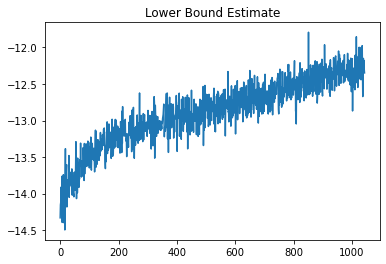

In [34]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

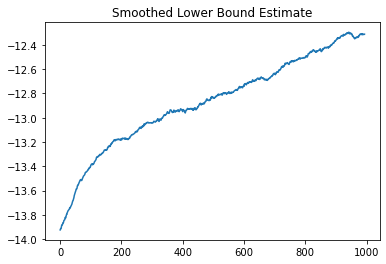

In [35]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [36]:
best_mu = best_lambda[0]

best_l = np.zeros((4, 4))
best_l[:, 0] = best_lambda[1][0:4]
best_l[1:4, 1] = best_lambda[1][4:7]
best_l[2:4, 2] = best_lambda[1][7:9]
best_l[3:4, 3] = best_lambda[1][9:10]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.50897801,  0.18178089,  1.03088999, -0.13396406])

Text(0.5, 1.0, 'Posterior density of alpha')

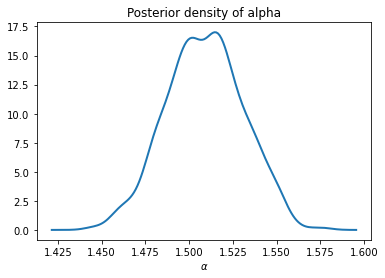

In [37]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde = gaussian_kde(best_alpha)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

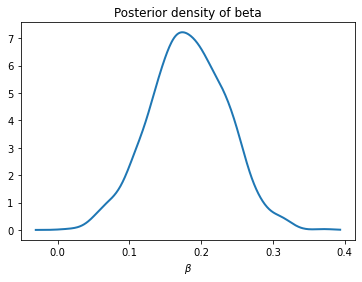

In [38]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde = gaussian_kde(best_beta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

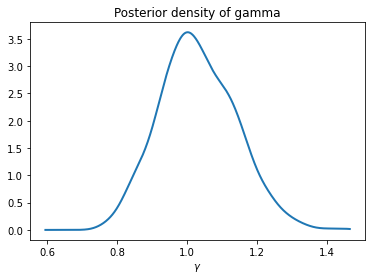

In [39]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde = gaussian_kde(best_gamma)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

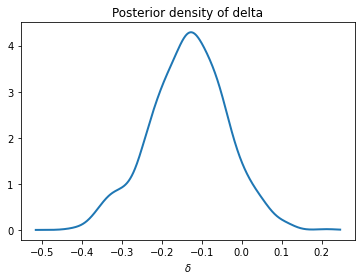

In [40]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde = gaussian_kde(best_delta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')